# 0.0. IMPORTS

In [1]:
import math
import utils
import random
import pickle
import requests
import warnings
import inflection
import yaml
import numpy  as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from datetime                   import datetime
from scipy                      import stats  as ss
from scipy.stats                import chi2_contingency
from boruta                     import BorutaPy
from matplotlib                 import pyplot as plt
from datetime                   import datetime, timedelta
from IPython.display            import Image
from IPython.core.display       import HTML
from multiprocessing            import cpu_count
from tabulate                   import tabulate
from copy                       import deepcopy

from sklearn.base               import clone, BaseEstimator, TransformerMixin
from sklearn.model_selection    import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline           import Pipeline
from sklearn.compose            import ColumnTransformer
from sklearn.impute             import KNNImputer
from sklearn.metrics            import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.ensemble           import RandomForestRegressor
from sklearn.linear_model       import LinearRegression, Lasso
from sklearn.preprocessing      import RobustScaler, MinMaxScaler, LabelEncoder, FunctionTransformer, OneHotEncoder


## 0.1. Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    """
    Performs k-fold cross-validation for a given model.

    Parameters:
    - x_training (DataFrame): Training dataset containing features and target variable.
    - kfold (int): Number of folds for cross-validation.
    - model_name (str): Name of the model.
    - model: Machine learning model object with `fit` and `predict` methods.
    - verbose (bool, optional): If True, print information for each fold. Default is False.

    Returns:
    - DataFrame: A DataFrame containing cross-validation results including mean and standard deviation of MAE, MAPE, and RMSE.
    """
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


In [3]:
def mean_percentage_error( y, yhat ):
    """
    Calculates the mean percentage error between actual and predicted values.

    Parameters:
    - y (array-like): Array of actual target values.
    - yhat (array-like): Array of predicted target values.

    Returns:
    - float: Mean percentage error.
    """
    return np.mean( ( y - yhat ) / y )

In [4]:
def mean_absolute_percentage_error( y, yhat ):
    """
    Calculates the mean absolute percentage error between actual and predicted values.

    Parameters:
    - y (array-like): Array of actual target values.
    - yhat (array-like): Array of predicted target values.

    Returns:
    - float: Mean absolute percentage error.
    """
    return np.mean( np.abs( ( y - yhat ) / y ) )

In [5]:
def ml_error( model_name, y, yhat ):
    """
    Calculate evaluation metrics for a machine learning model.

    Parameters:
    - model_name (str): Name of the model.
    - y (array-like): Array of actual target values.
    - yhat (array-like): Array of predicted target values.

    Returns:
    - DataFrame: DataFrame containing evaluation metrics (MAE, MAPE, RMSE) for the model.
    """
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

In [6]:
def cramer_v( x, y ):
    """
    Calculates Cramer's V statistic for categorical-categorical association.

    Parameters:
    - x (array-like): Array or Series containing categorical data.
    - y (array-like): Array or Series containing categorical data.

    Returns:
    - float: Cramer's V statistic.
    """
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [7]:
def snake_to_title(snake_str):
    """
    Convert a snake_case string to title case.

    Args:
    - snake_str (str): The snake_case string to be converted.

    Returns:
    str: The title case version of the input string.
    """
    words = snake_str.split('_')
    capitalized_words = [word.capitalize() for word in words]
    return ' '.join(capitalized_words)


In [8]:
def x2_test(dataframe, var_a, var_b, voi=None):

    """
    Perform chi-square test and visualization for association analysis between two categorical variables.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the data.
    - var_a (str): The name of the first categorical variable.
    - var_b (str): The name of the second categorical variable.
    - voi (str, optional): The name of the variable of interest.

    Returns:
    None
    """
    # Create a copy of the inpt data frame
    df1 = dataframe.copy()
    
    # Format data to a contingency table
    df = pd.crosstab(df1[var_a], df1[var_b])

    # Perform a Chi Square test
    chi2, p_value, dof, _ = chi2_contingency(df)

    # Perform pairwise Chi-square tests
    pairwise_results = {}
    for i in range(len(df.columns)):
        for j in range(i + 1, len(df.columns)):
            contingency_table = pd.crosstab(df.iloc[:, i], df.iloc[:, j])
            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            pairwise_results[f"{df.columns[i]} vs {df.columns[j]}"] = {
                "Chi-square": np.round(chi2, 2),
                "P-value": p_value,
            }

    # Adjust p-values using Bonferroni correction
    alpha = 0.05
    num_comparisons = len(pairwise_results)
    adjusted_alpha = alpha / num_comparisons

    # Plotting
    fig, ax = plt.subplots(3, 1, figsize=(12, 12))
    plt.subplots_adjust(hspace=0.5)

    # Subplot 1: Bar plot
    df_X = df1[[var_a, var_b]].groupby([var_b]).mean().reset_index().round(2)
    df_SD = df1[[var_a, var_b]].groupby([var_b]).std().reset_index().round(2)
    df_st = pd.merge(df_X, df_SD, on=var_b, how="outer")
    df_st.columns = [snake_to_title(var_b), "mean", "SD"]

    colors = plt.cm.viridis(np.linspace(0, 1, len(df_st)))
    bars = ax[0].bar(df_st[snake_to_title(var_b)], df_st["mean"], color=colors)

    for i, bar in enumerate(bars):
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        yerr = df_st["SD"][i]  # Get positive standard deviation
        ax[0].errorbar(x, y, yerr=[[0], [yerr]], color="black")

    ax[0].set_xlabel(f"{snake_to_title(var_b)}")
    ax[0].set_ylabel(f"Mean {voi}")
    ax[0].set_title(f"Mean {voi} by {snake_to_title(var_b)} with Standard Deviation")
    ax[0].set_xticks(range(len(df_st[snake_to_title(var_b)])))
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)

    # Subplot 2: Overall Chi-square test result
    chi2, p_value, dof, _ = chi2_contingency(df)
    table = [
        ["Chi-square statistic:", np.round(chi2, 2)],
        ["P-value:", p_value],
        ["Degrees of freedom:", dof],
    ]
    ax[1].axis("off")  # Hide axes
    ax[1].table(cellText=table, loc="center")
    ax[1].set_title("Overall Chi-square test result")

    # Subplot 3: Table
    table_data = []
    for comparison, result in pairwise_results.items():
        row = [comparison, np.round(result["Chi-square"], 2), result["P-value"]]
        if result["P-value"] < adjusted_alpha:
            row.append("Significant at adjusted alpha level")
        else:
            row.append("")
        table_data.append(row)

    ax[2].axis("off")  # Hide axes
    ax[2].table(
        cellText=table_data,
        colLabels=["Comparison", "Chi-square statistic", "P-value", "Significance"],
        loc="center",
    )
    ax[2].set_title("Pairwise Chi-square comparison with Bonferroni correction")

    plt.show()

In [9]:
def jupyter_settings():
    """
    Configure settings for Jupyter Notebook environment.

    This function sets up the following configurations:
    - Inline matplotlib plots
    - 'bmh' style for plots
    - Adjusted figure size and font size for plots
    - Expanded display for pandas DataFrame
    - Set seaborn defaults

    """
    %matplotlib inline
    # %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [10]:
def import_config(path_yaml):
    '''
    Import configuration settings from a YAML file.

    Parameters:
    - path_yaml (str): The path to the YAML configuration file.

    Returns:
    - dict: A dictionary containing the configuration settings loaded from the YAML file.

    Example:
    # config = import_config('config.yaml')
    # print(config)
    {'key1': 'value1', 'key2': 'value2', ...}
    '''
    with open(path_yaml) as config_file:
        config = yaml.safe_load(config_file)
    return config

In [11]:
jupyter_settings()

### 0.1.2. Config

The _'yaml'_ file will act as a shortcut for a few functions to optimize both the code and the process of coding.

In [12]:
config = import_config('config.yaml')
config

{'split': {'seed': 42, 'test_size': 0.2},
 'data': {'raw_path': '../data/raw/raw_data.csv',
  'trusted_path': '../data/df1_no_nas.csv',
  'train_path': '../data/train.csv',
  'test_path': '../data/test.csv',
  'store_path': '../data/store.csv',
  'trusted2_path': '../data/trusted.csv',
  'val_path': '../data/x_val_nonas.csv'},
 'image': {'path': '../images/mind_map.png'}}

## 0.2. Loading data

Load code from source and merge the two data frames of interest.

In [13]:
# Load raw data
df_sales_raw = pd.read_csv( config['data']['train_path'], low_memory=False )
df_store_raw = pd.read_csv( config['data']['store_path'], low_memory=False )

# merge DataFrames
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )


In [12]:
df_raw.shape

(1017209, 18)

Create a class to format the columns in the data frame. The goal is to optimize the coding process.

In [12]:
# Class to format the raw data frame

class FormatRawColumns_(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = self.rename_columns(X)

        return X
    
    def rename_columns(self, dataframe):
        # Copy the data frame
        df = dataframe.copy()

        # List the columns names
        cols_raw = list(df.columns)

        # Convert headers to snakecase format
        snakecase = lambda x: inflection.underscore( x )

        # Implement new column names
        cols_new = list( map( snakecase, cols_raw ) )

        # replace the dataframe column names with the newly formatted names
        df.columns = cols_new

        return df

Instantiate the pipeline for column formatting.

In [14]:
# Create a pipeline to rename the data frame
format_data_pipe = Pipeline([
    ("rename", utils.FormatRawColumns())
])

Use the class to format column names, convert the date to appropriate format.

In [15]:
# Rename dataframe columns using Pipeline
df_raw = format_data_pipe.fit_transform(df_raw)
df_raw['date'] = pd.to_datetime(df_raw['date'])
# df_raw = df_raw.loc[df_raw['sales']!=0,]
df_raw.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [16]:
dt_field = [
['header','description'],
['Id                              '    , 'an Id that represents a (Store, Date) duple within the test set'],                                                                                                                                                                          
['Store                           '    , 'a unique Id for each store'],
['Day of Week                     '    , 'Corresponding day of the week for the date'],
['Date                            '    , 'The date of the register'],
['Sales                           '    , 'the turnover for any given day (this is what you are predicting)'],
['Customers                       '    , 'the number of customers on a given day'],
['Open                            '    , 'an indicator for whether the store was open: 0 = closed, 1 = open'],
['StateHoliday                    '    , 'indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, d = None'],
['SchoolHoliday                   '    , 'indicates if the (Store, Date) was affected by the closure of public schools'],
['StoreType                       '    , 'differentiates between 4 different store models: a, b, c, d'],
['Assortment                      '    , 'describes an assortment level: a = basic, b = extra, c = extended'],
['CompetitionDistance             '    , 'distance in meters to the nearest competitor store'],
['CompetitionOpenSince[Month/Year]'    , 'gives the approximate year and month of the time the nearest competitor was opened'],
['Promo                           '    , 'indicates whether a store is running a promo on that day'],
['Promo2                          '    , 'Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating'],
['Promo2Since[Year/Week]          '    , 'describes the year and calendar week when the store started participating in Promo2'],
['PromoInterval                   '    , 'describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store']
]
print('Description of the studied variables.\n')
print('* * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * *\n')
print( tabulate( dt_field, headers='firstrow' ) )

Description of the studied variables.

* * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * ** * * *

header                            description
--------------------------------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Id                                an Id that represents a (Store, Date) duple within the test set
Store                             a unique Id for each store
Day of Week                       Corresponding day of the week for the date
Date                              The date of the register
Sales                             the turnover for any given day (this is what you are predicting)
Customers                         the number of customers on a given day
Open                              an indicator for whether the store was open: 0 = closed, 1 = open

## 0.3. Split Data into Training, Validation, and Test sets

This project deals with time-dependent data and requires proper partitioning techniques. Also, the business problem is looking for a 6-week estimation. Therefore, I am seeparating the test set with the last 6 weeks of the data set. For the remaining data, I am using chronological split with a 70%:30% ratio for the train and validation split, respectively. The goal with this technique is to preserve the temporal dependencies and trends in the data, while also simulating real-world scenarios where the model encounters actual data.

Finding the Minimum and Maximal dates in the dataset

In [15]:
print(f"Date min: {df_raw['date'].min()}")
print(f"Date max: {df_raw['date'].max()}")

Date min: 2013-01-01 00:00:00
Date max: 2015-07-31 00:00:00


Calculate the number of weeks between the first and the last day registered in the data set

In [16]:
week_diff = (df_raw['date'].max() - df_raw['date'].min())/ np.timedelta64(1,'W')
week_diff = round(week_diff)
print(week_diff)

134


Calculate the number of weeks each portion of the split should have

In [17]:
full_data = week_diff
train = 0.7
val = 0.3
test = 128
print(f'Test portion should have {full_data-test:.1f} weeks')
print(f'Validation portion should have {full_data*val:.1f} weeks')
print(f'Train portion should have {full_data*train:.1f} weeks')

Test portion should have 6.0 weeks
Validation portion should have 40.2 weeks
Train portion should have 93.8 weeks


Calculate the time windows for each partition

In [18]:
# Constants
test_weeks = 6
wts = 40
roof_val = pd.to_datetime('2015-06-18 00:00:00')
roof_train = pd.to_datetime('2014-09-10 00:00:00')

# Calculations
date_test = df_raw['date'].max()
floor_test = date_test - pd.Timedelta(weeks=test_weeks)
floor_val = roof_val - pd.Timedelta(weeks=wts)

# Output
print(f'Date max:                       {date_test}')
print(f'Window for test split:          {floor_test} and {date_test}')
print(f'Window for validation split:    {floor_val} and {roof_val}')
print(f'Window for train split: between {df_raw["date"].min()} and {roof_train}')


Date max:                       2015-07-31 00:00:00
Window for test split:          2015-06-19 00:00:00 and 2015-07-31 00:00:00
Window for validation split:    2014-09-11 00:00:00 and 2015-06-18 00:00:00
Window for train split: between 2013-01-01 00:00:00 and 2014-09-10 00:00:00


Splitting the original dataset into train, validation, and test

In [17]:
# Training dataset
X_train = df_raw[df_raw['date'] <= '2014-09-10']
y_train = X_train['sales']

# Validation dataset
X_val = df_raw[(df_raw['date'] >= '2014-09-11') & (df_raw['date'] <= '2015-06-18')]
y_val = X_val['sales']

# Test dataset
X_test = df_raw[df_raw['date'] >= '2015-06-19']
y_test = X_test['sales']

print( f'Training Min Date: {X_train["date"].min()}')
print( f'Training Max Date: {X_train["date"].max()}')

print( f'\nValidation Min Date: {X_val["date"].min()}')
print( f'Validation Max Date: {X_val["date"].max()}')

print( f'\nTest Min Date: {X_test["date"].min()}')
print( f'Test Max Date: {X_test["date"].max()}')

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2014-09-10 00:00:00

Validation Min Date: 2014-09-11 00:00:00
Validation Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


In [18]:
print(f'\nTrain Shape:{X_train.shape} --> {np.round((X_train.shape[0]/df_raw.shape[0])*100, 1)}% of raw data')
print(f'\nValidation Shape:{X_val.shape} --> {np.round((X_val.shape[0]/df_raw.shape[0])*100, 1)}% of raw data')
print(f'\nTest Shape:{X_test.shape} --> {np.round((X_test.shape[0]/df_raw.shape[0])*100, 1)}% of raw data')


Train Shape:(676109, 18) --> 66.5% of raw data

Validation Shape:(293155, 18) --> 28.8% of raw data

Test Shape:(47945, 18) --> 4.7% of raw data


# 1.0. Data Description

In [35]:
X_train.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
341100,1,3,2014-09-10,3275,448,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
341101,2,3,2014-09-10,4865,646,1,0,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
341102,3,3,2014-09-10,5164,659,1,0,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
341103,4,3,2014-09-10,8530,1206,1,0,0,0,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
341104,5,3,2014-09-10,4305,590,1,0,0,0,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.1. Data Types

Verify whether the data types need ay formatting. 

In [86]:
print(X_train.info())
print(X_val.info())

<class 'pandas.core.frame.DataFrame'>
Index: 561576 entries, 341100 to 1017190
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   store                         561576 non-null  int64         
 1   day_of_week                   561576 non-null  int64         
 2   date                          561576 non-null  datetime64[ns]
 3   sales                         561576 non-null  int64         
 4   customers                     561576 non-null  int64         
 5   open                          561576 non-null  int64         
 6   promo                         561576 non-null  int64         
 7   state_holiday                 561576 non-null  object        
 8   school_holiday                561576 non-null  int64         
 9   store_type                    561576 non-null  object        
 10  assortment                    561576 non-null  object        
 11  competition_

## 1.2. Missing Data

Checking whether the data present missing information

In [21]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(f'Missing train data:\n{X_train.isna().sum()/X_train.shape[0]*100}')


Missing train data:
store                            0.000000
day_of_week                      0.000000
date                             0.000000
sales                            0.000000
customers                        0.000000
open                             0.000000
promo                            0.000000
state_holiday                    0.000000
school_holiday                   0.000000
store_type                       0.000000
assortment                       0.000000
competition_distance             0.263567
competition_open_since_month    31.771800
competition_open_since_year     31.771800
promo2                           0.000000
promo2_since_week               49.468799
promo2_since_year               49.468799
promo_interval                  49.468799
dtype: float64


In [22]:
print(f'Missing validation data:\n{X_val.isna().sum()/X_val.shape[0]*100}')

Missing validation data:
store                            0.000000
day_of_week                      0.000000
date                             0.000000
sales                            0.000000
customers                        0.000000
open                             0.000000
promo                            0.000000
state_holiday                    0.000000
school_holiday                   0.000000
store_type                       0.000000
assortment                       0.000000
competition_distance             0.249356
competition_open_since_month    31.830943
competition_open_since_year     31.830943
promo2                           0.000000
promo2_since_week               51.227508
promo2_since_year               51.227508
promo_interval                  51.227508
dtype: float64


* 6 variables presented missing data. Only one variable presented less than 10 % missing. Two variables present about 31% of missing whereas 3 variables present 49 - 51% missing. The decision to either imput data or remove the variables will be made after the exploratory data analysis phase of this project.

## 1.3. Check Duplicates

Checking for duplicated data.

In [9]:
# Duplicates in train set
(X_train.duplicated().sum() / X_train.shape[0]) * 100

0.0

In [10]:
# Duplicates in validation set
(X_val.duplicated().sum() / X_val.shape[0]) * 100

0.0

* Data do not have any duplicates.

## 1.4. Descriptive Statistics

This is the initial glimpse on the data sets. Such initial analysis aims to help understand in the next steps of the project.

First, separate the numerical and categorical variables.

In [23]:
# Train set
num_attributes_train = X_train.select_dtypes( include=['int64', 'float64'] )
cat_attributes_train = X_train.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [24]:
# Validation set
num_attributes_val = X_val.select_dtypes( include=['int64', 'float64'] )
cat_attributes_val = X_val.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.4.1. Numerical attributes

Perform basic descriptive statistics on the data.

**Train data**

In [25]:
# Central Tendency - mean, medianS 
ct1 = pd.DataFrame( num_attributes_train.apply( np.mean ).round(decimals=2) ).T
ct2 = pd.DataFrame( num_attributes_train.apply( np.median ).round(decimals=2) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes_train.apply( np.std ).round(decimals=2) ).T 
d2 = pd.DataFrame( num_attributes_train.apply( min ).round(decimals=2) ).T 
d3 = pd.DataFrame( num_attributes_train.apply( max ).round(decimals=2) ).T 
d4 = pd.DataFrame( num_attributes_train.apply( lambda x: x.max() - x.min() ).round(decimals=2) ).T 
d5 = pd.DataFrame( num_attributes_train.apply( lambda x: x.skew() ).round(decimals=2) ).T 
d6 = pd.DataFrame( num_attributes_train.apply( lambda x: x.kurtosis() ).round(decimals=2) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.25,558.0,321.89,-0.00,-1.20
1,day_of_week,1.0,7.0,6.0,4.00,4.0,2.00,0.00,-1.25
2,sales,0.0,38037.0,38037.0,5678.59,5635.0,3800.70,0.68,1.93
3,customers,0.0,7388.0,7388.0,630.50,606.0,463.37,1.60,7.06
4,open,0.0,1.0,1.0,0.83,1.0,0.38,-1.76,1.11
5,promo,0.0,1.0,1.0,0.37,0.0,0.48,0.53,-1.72
6,school_holiday,0.0,1.0,1.0,0.19,0.0,0.39,1.57,0.45
7,competition_distance,20.0,75860.0,75840.0,5419.73,NaN,7692.52,2.93,13.01
8,competition_open_since_month,1.0,12.0,11.0,7.22,NaN,3.21,-0.17,-1.25
9,competition_open_since_year,1900.0,2015.0,115.0,2008.68,NaN,6.08,-7.74,124.48


**Validation Data**

In [26]:
# Central Tendency - mean, medianS 
ct1 = pd.DataFrame( num_attributes_val.apply( np.mean ).round(decimals=2) ).T
ct2 = pd.DataFrame( num_attributes_val.apply( np.median ).round(decimals=2) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes_val.apply( np.std ).round(decimals=2) ).T 
d2 = pd.DataFrame( num_attributes_val.apply( min ).round(decimals=2) ).T 
d3 = pd.DataFrame( num_attributes_val.apply( max ).round(decimals=2) ).T 
d4 = pd.DataFrame( num_attributes_val.apply( lambda x: x.max() - x.min() ).round(decimals=2) ).T 
d5 = pd.DataFrame( num_attributes_val.apply( lambda x: x.skew() ).round(decimals=2) ).T 
d6 = pd.DataFrame( num_attributes_val.apply( lambda x: x.kurtosis() ).round(decimals=2) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.91,558.0,321.95,-0.00,-1.20
1,day_of_week,1.0,7.0,6.0,4.00,4.0,2.00,0.00,-1.24
2,sales,0.0,38722.0,38722.0,5949.97,5970.0,3974.77,0.56,1.44
3,customers,0.0,5494.0,5494.0,639.10,619.0,470.84,1.56,6.87
4,open,0.0,1.0,1.0,0.82,1.0,0.38,-1.70,0.88
5,promo,0.0,1.0,1.0,0.41,0.0,0.49,0.38,-1.85
6,school_holiday,0.0,1.0,1.0,0.13,0.0,0.34,2.17,2.73
7,competition_distance,20.0,75860.0,75840.0,5458.08,NaN,7776.56,2.93,12.96
8,competition_open_since_month,1.0,12.0,11.0,7.22,NaN,3.21,-0.17,-1.26
9,competition_open_since_year,1900.0,2015.0,115.0,2008.71,NaN,5.76,-6.87,112.25


Both train and validation datasets presented close scores, suggesting that the split of the data being able to maintain the original characteristics of both trin and validation data sets.

### 1.4.2. Categorical attributes

Cheking the unique values for the categorical variables.

In [27]:
print(f"State holiday uniques: {X_train['state_holiday'].unique()}\n")
print(f"Store type uniques: {X_train['store_type'].unique()}\n")
print(f"Assortment uniques: {X_train['assortment'].unique()}\n")
print(f"Promo interval uniques: {X_train['promo_interval'].unique()}")

State holiday uniques: ['0' 'a' 'b' 'c']

Store type uniques: ['c' 'a' 'd' 'b']

Assortment uniques: ['a' 'c' 'b']

Promo interval uniques: [nan 'Jan,Apr,Jul,Oct' 'Mar,Jun,Sept,Dec' 'Feb,May,Aug,Nov']


Label variables for clarity:

In [18]:
# Assortment
X_train.loc[:,"assortment"] = X_train["assortment"].apply(
    lambda x: (
        "basic"
        if x == "a"
        else (
            "extra" 
            if x == "b" 
            else "extended"
            )
        )
    )

# state holiday
X_train.loc[:,"state_holiday"] = X_train["state_holiday"].apply(
    lambda x: (
        "public_holiday"
        if x == "a"
        else (
            "easter_holiday" 
            if x == "b" 
            else (
                "christmas"
                if x == "c"
                else "regular_day"
            )
        )
    )
)

In [159]:
print(f"State holiday uniques: {X_train['state_holiday'].unique()}\n")
print(f"Store type uniques: {X_train['store_type'].unique()}\n")
print(f"Assortment uniques: {X_train['assortment'].unique()}\n")
print(f"Promo interval uniques: {X_train['promo_interval'].unique()}\n")

State holiday uniques: ['regular_day' 'public_holiday' 'easter_holiday' 'christmas']

Store type uniques: ['c' 'a' 'd' 'b']

Assortment uniques: ['basic' 'extended' 'extra']

Promo interval uniques: [nan 'Jan,Apr,Jul,Oct' 'Mar,Jun,Sept,Dec' 'Feb,May,Aug,Nov']



In [30]:
print(f"State holiday uniques: {X_val['state_holiday'].unique()}\n")
print(f"Store type uniques: {X_val['store_type'].unique()}\n")
print(f"Assortment uniques: {X_val['assortment'].unique()}\n")
print(f"Promo interval uniques: {X_val['promo_interval'].unique()}\n")

State holiday uniques: ['0' 'a' 'b' 'c']

Store type uniques: ['c' 'a' 'd' 'b']

Assortment uniques: ['a' 'c' 'b']

Promo interval uniques: [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']



In [19]:
# Assortment
X_val.loc[:,"assortment"] = X_val["assortment"].apply(
    lambda x: (
        "basic"
        if x == "a"
        else (
            "extra" 
            if x == "b" 
            else "extended"
            )
        )
    )

# state holiday
X_val.loc[:,"state_holiday"] = X_val["state_holiday"].apply(
    lambda x: (
        "public_holiday"
        if x == "a"
        else (
            "easter_holiday" 
            if x == "b" 
            else (
                "christmas"
                if x == "c"
                else "regular_day"
            )
        )
    )
)

In [32]:
print(f"State holiday uniques: {X_val['state_holiday'].unique()}\n")
print(f"Store type uniques: {X_val['store_type'].unique()}\n")
print(f"Assortment uniques: {X_val['assortment'].unique()}\n")
print(f"Promo interval uniques: {X_val['promo_interval'].unique()}\n")

State holiday uniques: ['regular_day' 'public_holiday' 'easter_holiday' 'christmas']

Store type uniques: ['c' 'a' 'd' 'b']

Assortment uniques: ['basic' 'extended' 'extra']

Promo interval uniques: [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']



**Train Data**

Box plotting the sales by each of the categorical characteristics for the training data.

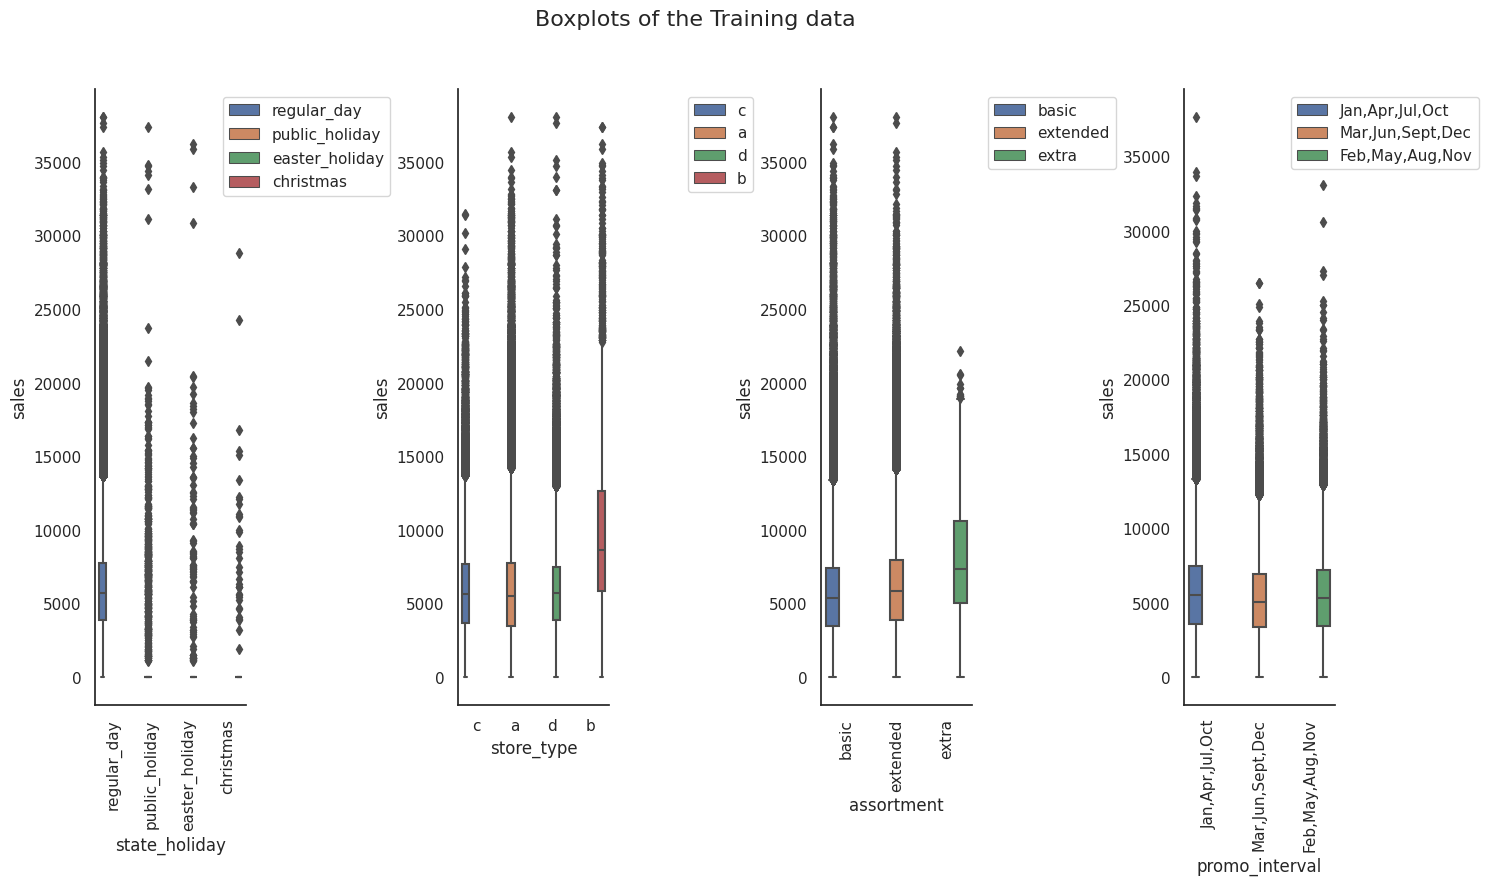

In [55]:
plt.figure(figsize=(16,8))

# Subplot 1 - State holidays (x-axis) vs Sales (y-axis)
plt.subplot( 1, 4, 1 )
sns.set_style(style='white')
sns.boxplot( x='state_holiday', y='sales', data=X_train, hue = 'state_holiday' )
plt.xticks( rotation = 90)
plt.gca().spines['top'].set_visible(False)  # Remove top horizontal axis
plt.gca().spines['right'].set_visible(False)  # Remove right vertical axis
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))


# Subplot 2 - Store type (x-axis) vs Sales (y-axis)
plt.subplot( 1, 4, 2 )
sns.boxplot( x='store_type', y='sales', data=X_train, hue = 'store_type' )
sns.set_style(style='white')
plt.gca().spines['top'].set_visible(False)  # Remove top horizontal axis
plt.gca().spines['right'].set_visible(False)  # Remove right vertical axis
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))

# Subplot 3 - Assortment (x-axis) vs Sales (y-axis)
plt.subplot( 1, 4, 3 )
sns.boxplot( x='assortment', y='sales', data=X_train, hue = 'assortment' )
sns.set_style(style='white')
plt.xticks( rotation = 90)
plt.gca().spines['top'].set_visible(False)  # Remove top horizontal axis
plt.gca().spines['right'].set_visible(False)  # Remove right vertical axis
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))

# Subplot 4 - Promo interval (x-axis) vs Sales (y-axis)
plt.subplot( 1, 4, 4 )
sns.boxplot( x='promo_interval', y='sales', data=X_train, hue = 'promo_interval' )
sns.set_style(style='white')
plt.xticks( rotation = 90)
plt.gca().spines['top'].set_visible(False)  # Remove top horizontal axis
plt.gca().spines['right'].set_visible(False)  # Remove right vertical axis
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))

# Add space between plots
plt.subplots_adjust(wspace=1.4)

# Add title
plt.suptitle("Boxplots of the Training data", fontsize=16)


plt.show();

**Validation Data**

Box plotting the sales by each of the categorical characteristics for the Validation data.

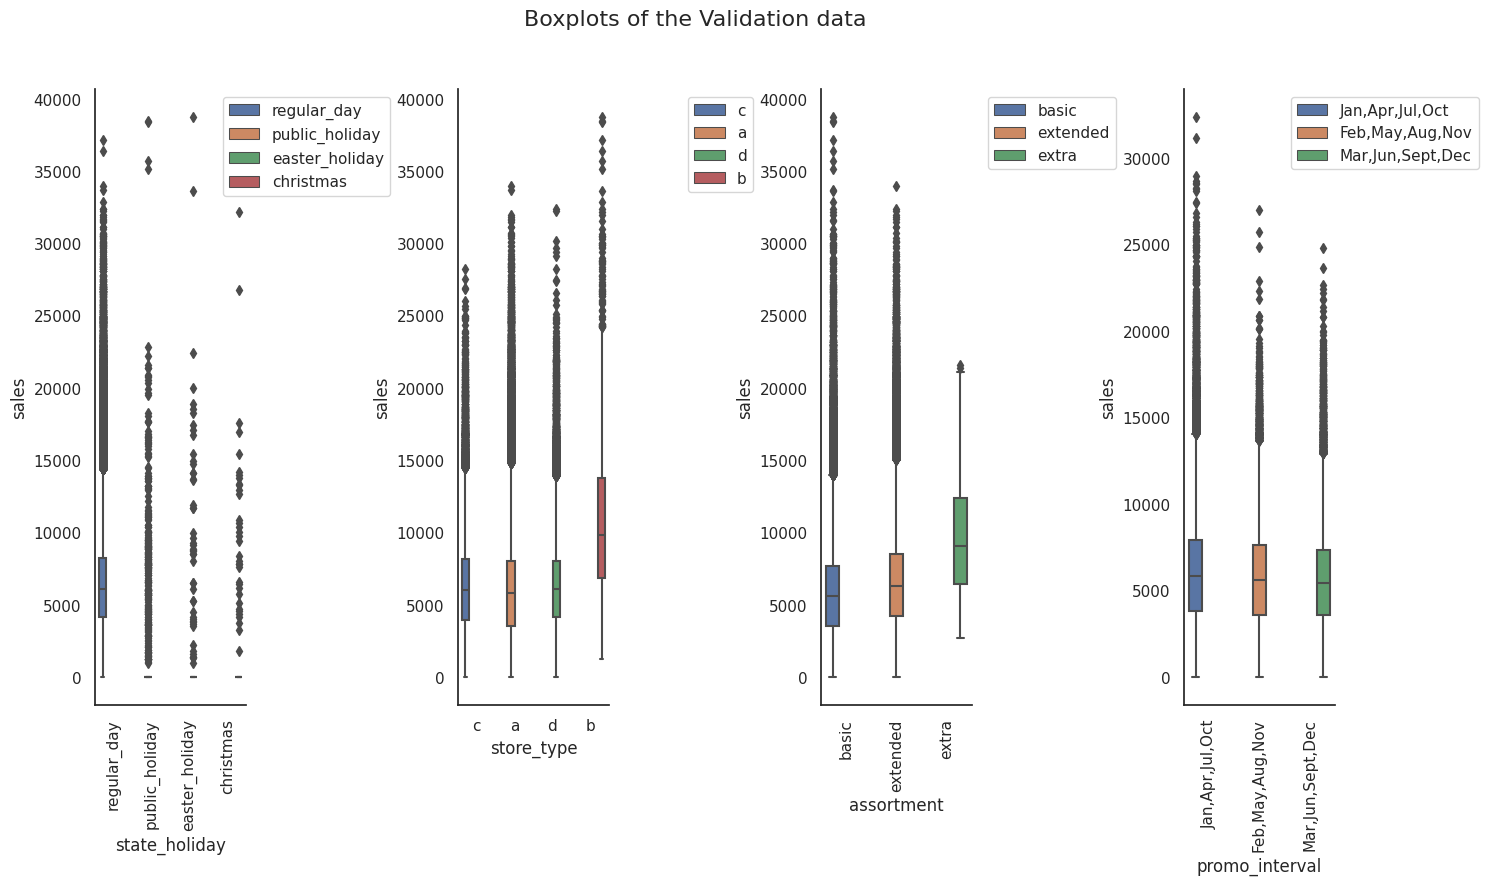

In [56]:
plt.figure(figsize=(16,8))

# Subplot 1 - State holidays (x-axis) vs Sales (y-axis)
plt.subplot( 1, 4, 1 )
sns.set_style(style='white')
sns.boxplot( x='state_holiday', y='sales', data=X_val, hue = 'state_holiday' )
plt.xticks( rotation = 90)
plt.gca().spines['top'].set_visible(False)  # Remove top horizontal axis
plt.gca().spines['right'].set_visible(False)  # Remove right vertical axis
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))

# Subplot 2 - Store type (x-axis) vs Sales (y-axis)
plt.subplot( 1, 4, 2 )
sns.boxplot( x='store_type', y='sales', data=X_val, hue = 'store_type' )
sns.set_style(style='white')
plt.gca().spines['top'].set_visible(False)  # Remove top horizontal axis
plt.gca().spines['right'].set_visible(False)  # Remove right vertical axis
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))

# Subplot 3 - Assortment (x-axis) vs Sales (y-axis)
plt.subplot( 1, 4, 3 )
sns.boxplot( x='assortment', y='sales', data=X_val, hue = 'assortment' )
sns.set_style(style='white')
plt.xticks( rotation = 90)
plt.gca().spines['top'].set_visible(False)  # Remove top horizontal axis
plt.gca().spines['right'].set_visible(False)  # Remove right vertical axis
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))

# Subplot 4 - Promo interval (x-axis) vs Sales (y-axis)
plt.subplot( 1, 4, 4 )
sns.boxplot( x='promo_interval', y='sales', data=X_val, hue = 'promo_interval' )
sns.set_style(style='white')
plt.xticks( rotation = 90)
plt.gca().spines['top'].set_visible(False)  # Remove top horizontal axis
plt.gca().spines['right'].set_visible(False)  # Remove right vertical axis
plt.legend(loc='upper right', bbox_to_anchor=(2, 1))

# Add space between plots
plt.subplots_adjust(wspace=1.4)

# Add title
plt.suptitle("Boxplots of the Validation data", fontsize=16)


plt.show();

# 2.0. Exploratory Data Analysis

## 2.0.0. Generating Hypothesis

### 2.0.1. Hypothesis Mindmap

![Image]( ../img/mind_map_EN.png )

The hypothesis mindmap above provides a $\color{red} thorough$ description of daily store sales. That includes assumptions about location, clients, stores, products, and timing. $\color{red} However$, the business problem at hand and the data available to work out the solution provide information mostly on timing, sales, and stores. $\color{red} Therefore$, the studying hypothesis will be investigated in the scope of the business problem and the data avaialble.



### 2.0.2. Hypothesis creation

#### H1 - Sales are influenced by store type.

#### H2 - Sales are influenced byy store assortment.

#### H3 - Sales are influenced by timing.

Hypothesis will be validated over the EDA.

## 2.1. Univariate Analysis

### 2.1.1. Response Variable

/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


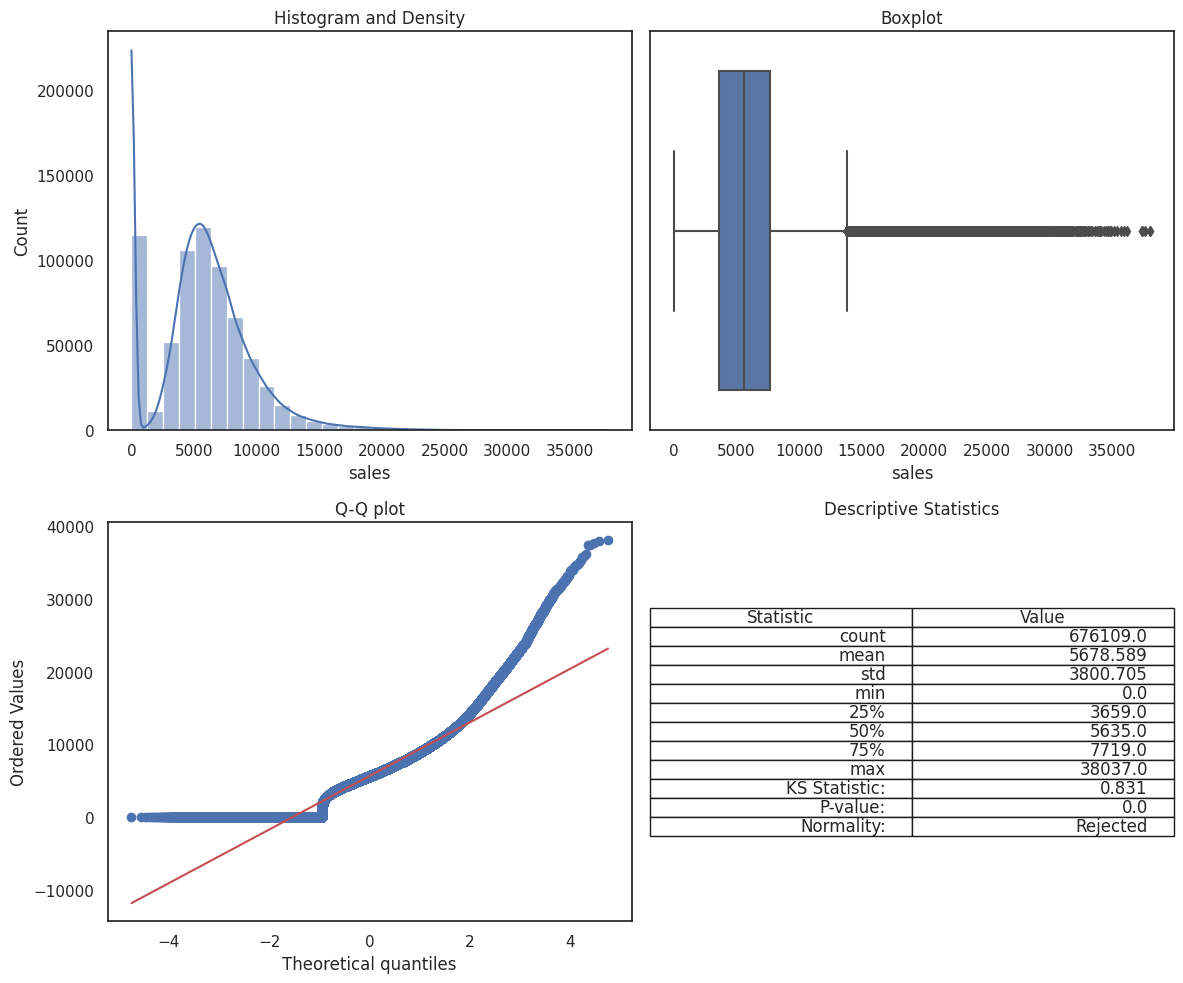

In [62]:
# Perform Kolmogorov-Smirnov test
# This compares the sample data to a normal distribution with mean 0 and standard deviation 1
ks_statistic, ks_p_value = ss.kstest(X_train["sales"], "norm")

# Check summary statistics of 'sales' column
sales_summary = X_train["sales"].describe().round(3)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot histogram and density
sns.histplot(X_train["sales"], bins=30, ax=axes[0, 0], kde=True)
axes[0, 0].set_title("Histogram and Density")

# Plot boxplot
sns.boxplot(x="sales", data=X_train, ax=axes[0, 1])
axes[0, 1].set_title("Boxplot")

# Plot Q-Q plot
ss.probplot(X_train["sales"], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Q-Q plot")

# Create table
table_data = sales_summary.to_frame().reset_index().values
table_data = [[str(entry) for entry in row] for row in table_data]
table_data.append(["KS Statistic:", str(np.round(ks_statistic,3))])
table_data.append(["P-value:", str(ks_p_value)])
if ks_p_value < 0.05:
    table_data.append(["Normality:", "Rejected"])
else:
    table_data.append(["Normality:", "Not rejected"])

axes[1, 1].axis("off")  # Hide axis for the table
axes[1, 1].table(cellText=table_data, loc="center", colLabels=["Statistic", "Value"])
axes[1, 1].set_title("Descriptive Statistics")

plt.tight_layout()
plt.show()

The raw response variable ('sales') violates the assumption of normally distributed data. Below I verified whether a logarithmic transformation would fix this characteristic of this variable to optimize the modeling far ahead in the project.

/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site

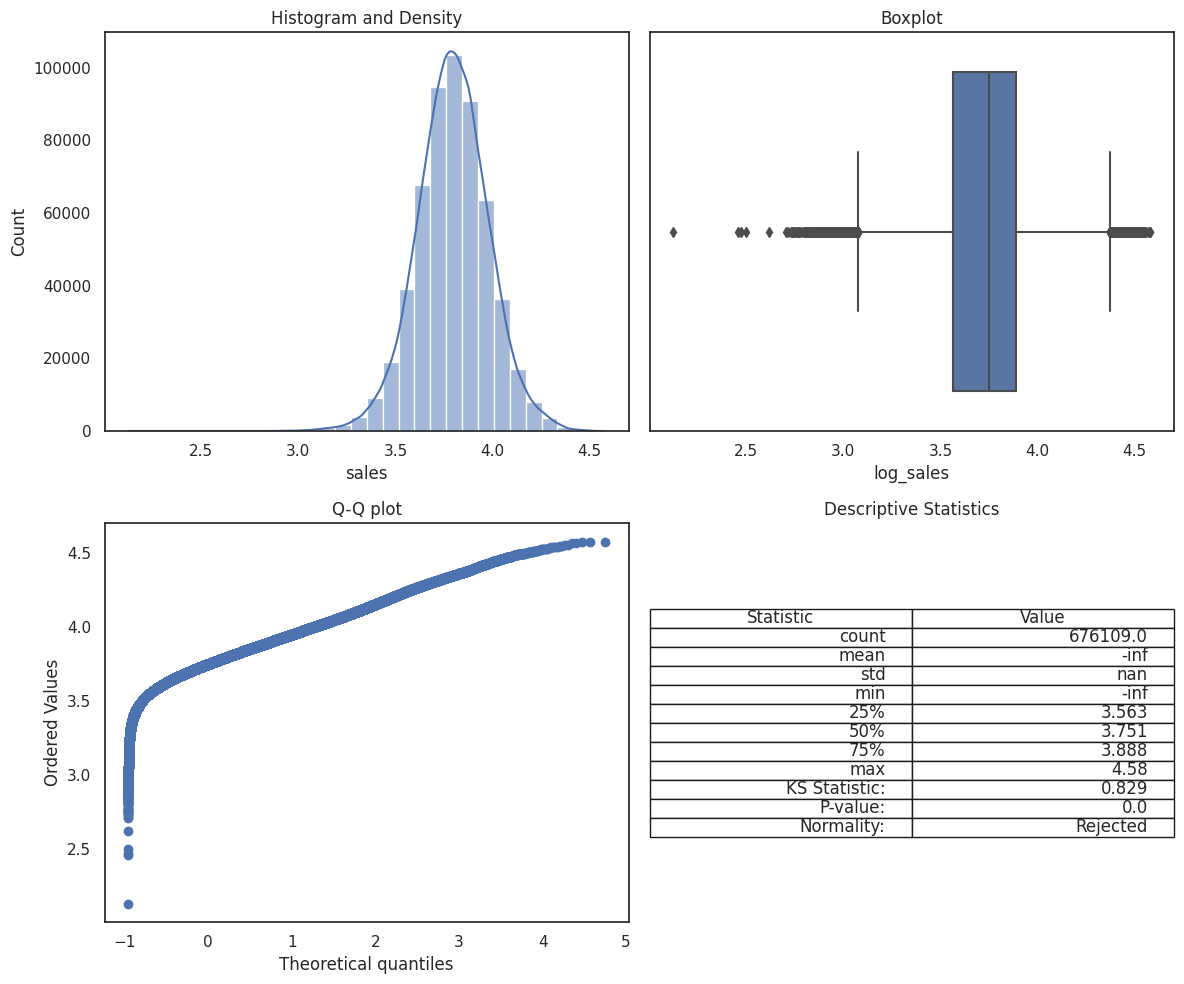

In [64]:
# Perform Kolmogorov-Smirnov test
# This compares the sample data to a normal distribution with mean 0 and standard deviation 1
ks_statistic, ks_p_value = ss.kstest(np.log10(X_train["sales"]), "norm")

# Check summary statistics of 'sales' column
sales_summary = np.log10(X_train["sales"]).describe().round(3)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot histogram and density
sns.histplot(np.log10(X_train["sales"]), bins=30, ax=axes[0, 0], kde=True)
axes[0, 0].set_title("Histogram and Density")

# Plot boxplot
X_train["log_sales"] = np.log10(X_train["sales"])

sns.boxplot(x="log_sales", data=X_train, ax=axes[0, 1])
axes[0, 1].set_title("Boxplot")

# Plot Q-Q plot
ss.probplot(np.log10(X_train["sales"]), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Q-Q plot")

# Create table
table_data = sales_summary.to_frame().reset_index().values
table_data = [[str(entry) for entry in row] for row in table_data]
table_data.append(["KS Statistic:", str(np.round(ks_statistic,3))])
table_data.append(["P-value:", str(ks_p_value)])
if ks_p_value < 0.05:
    table_data.append(["Normality:", "Rejected"])
else:
    table_data.append(["Normality:", "Not rejected"])

axes[1, 1].axis("off")  # Hide axis for the table
axes[1, 1].table(cellText=table_data, loc="center", colLabels=["Statistic", "Value"])
axes[1, 1].set_title("Descriptive Statistics")

plt.tight_layout()
plt.show()

The log transformation of the response variable slightly improved the shape of the distribution but still held the broken assumption of normality. Therefore, another measure shold be taken in order to opimize the data before feeding it to the machine learning models.  

Below, I dropped the log transformed response variable to free the environment.

In [68]:
X_train = X_train.drop("log_sales", axis = 1)

#### 2.1.2.0. Separate Numerical and Categorical data

In [16]:
num_attributes = X_train.select_dtypes( include=['int64', 'float64'] )
cat_attributes = X_train.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

To expand the initial analysis of the data, I have separated he nmerical and categorical data for plotting.

### 2.1.2. Numerical Variables

Then, I plotted he distribution of all numeric variables to better understand each of them.

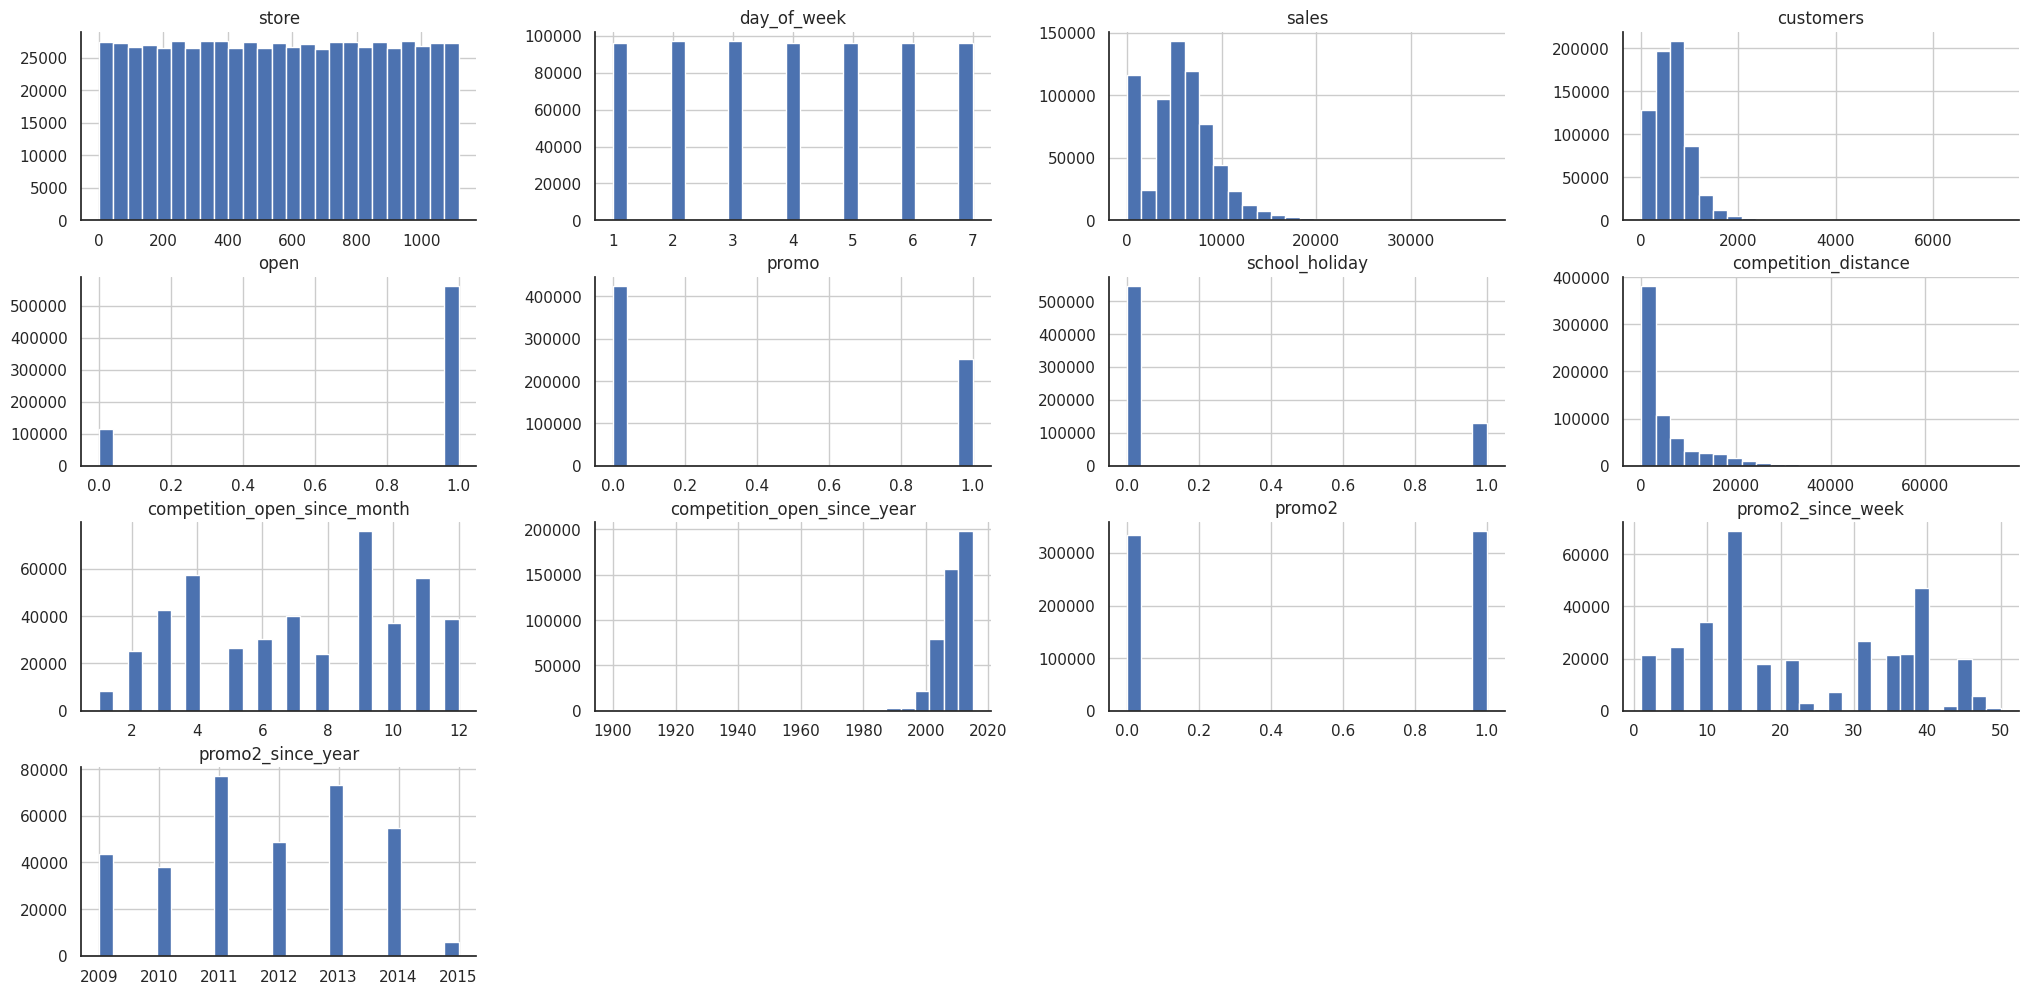

In [21]:
num_attributes.hist( bins=25 )

sns.set_style(style='white')

sns.despine()
plt.show()


The data distribution of the numerical variables shows that few of them are binary and may require some treatment to be used further.

### 2.1.3. Categorical Variables

The categorical variable may play a key role to the modelling, so that it is important to carefully deal with these variables. Here, I plotted the data to visually inspect these categorical variables. Verify the counts as well as the density distribution for each factor within the variables.

/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/seaborn/_oldcore.py

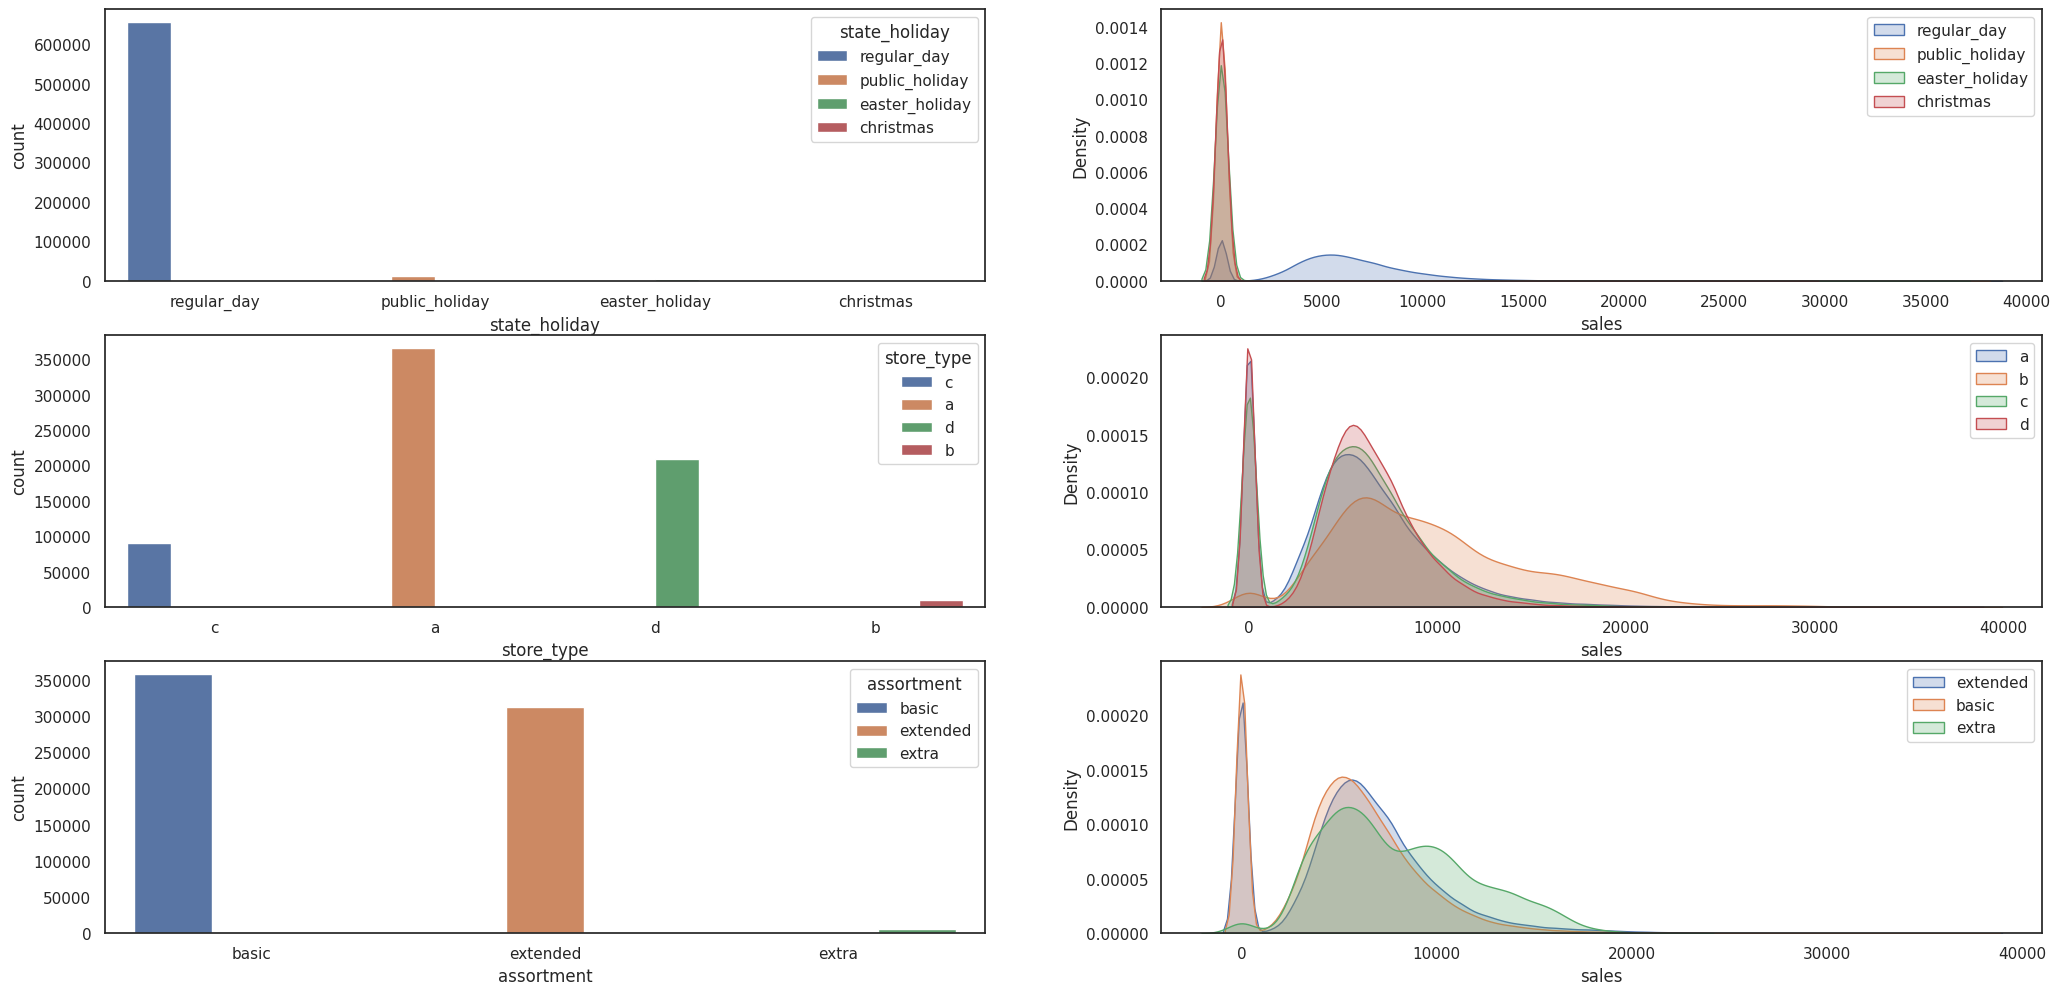

In [86]:
sns.set_style(style='white')

# state_holiday
plt.subplot( 3, 2, 1 )
# X_train = X_train[X_train['state_holiday'] != 'regular_day']
sns.countplot( x='state_holiday', data = X_train, hue = 'state_holiday')

plt.subplot( 3, 2, 2 )
sns.kdeplot( X_train[X_train['state_holiday'] == 'regular_day']['sales'], label='regular_day', fill=True ).legend(loc="upper right")
sns.kdeplot( X_train[X_train['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True ).legend(loc="upper right")
sns.kdeplot( X_train[X_train['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True ).legend(loc="upper right")
sns.kdeplot( X_train[X_train['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True ).legend(loc="upper right")
plt.ticklabel_format(style='plain', axis='y')
# Place the legend
plt.legend(loc="upper right")

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( x='store_type', data=X_train, hue = 'store_type' )

plt.subplot( 3, 2, 4 )
sns.kdeplot( X_train[X_train['store_type'] == 'a']['sales'], label='a', fill=True ).legend(loc="upper right")
sns.kdeplot( X_train[X_train['store_type'] == 'b']['sales'], label='b', fill=True ).legend(loc="upper right")
sns.kdeplot( X_train[X_train['store_type'] == 'c']['sales'], label='c', fill=True ).legend(loc="upper right")
sns.kdeplot( X_train[X_train['store_type'] == 'd']['sales'], label='d', fill=True ).legend(loc="upper right")

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( data = X_train, x = 'assortment', hue = 'assortment' )

plt.subplot( 3, 2, 6 )
sns.kdeplot( X_train[X_train['assortment'] == 'extended']['sales'], label='extended', fill=True ).legend(loc="upper right")
sns.kdeplot( X_train[X_train['assortment'] == 'basic']['sales'], label='basic', fill=True ).legend(loc="upper right")
sns.kdeplot( X_train[X_train['assortment'] == 'extra']['sales'], label='extra', fill=True ).legend(loc="upper right")

The distribution of the categorical data suggests that these may affect the modeling.

### 2.1.4 Hypothesis testing

#### 2.1.4.1 - H1: Sales are influenced by store type 

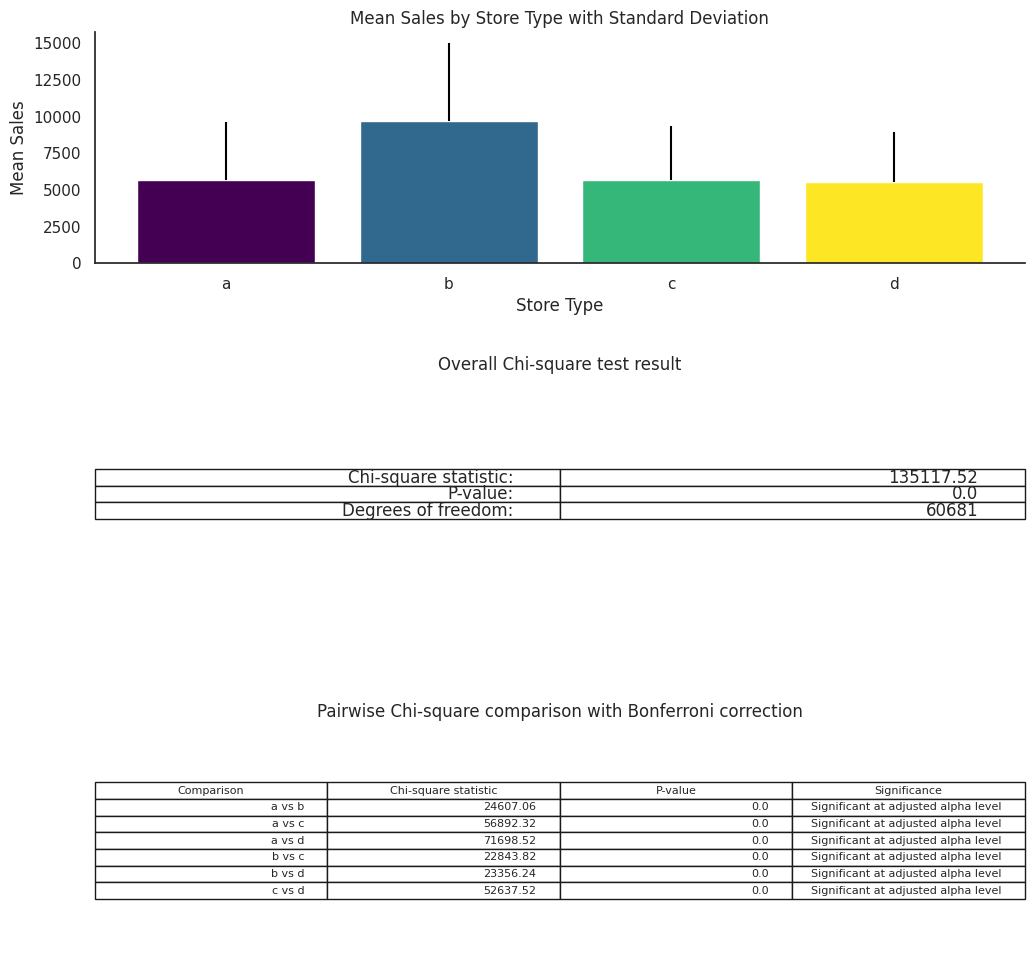

In [168]:
x2_test(X_train, 'sales','store_type',voi='Sales')

The store type showed a significant association with sales $\chi^{2}$(60681) = 135117.52, p< 0.001. This seems to represent the fact that, based on the pairwise with Bonferroni correction comparisons, the type of store influences the sales.

#### 2.1.4.2 - H2: Sales are influenced by store assortment. 

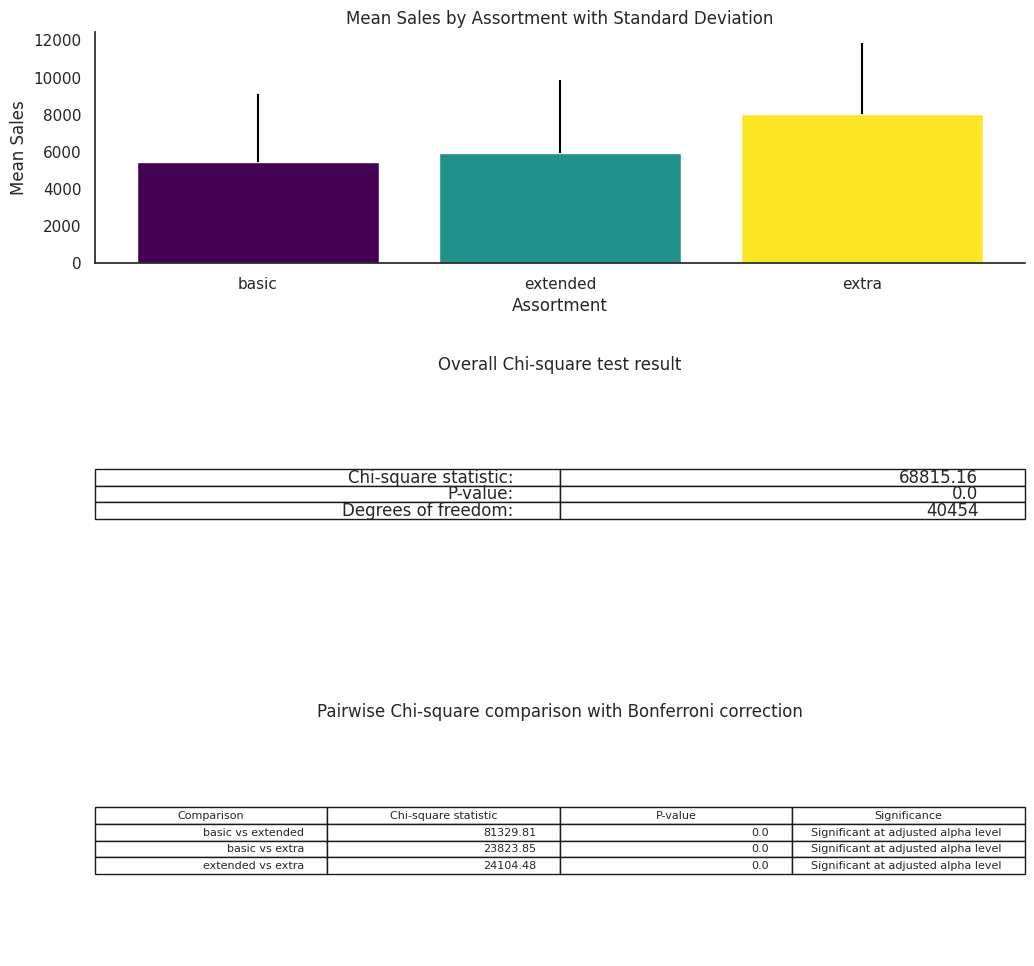

In [170]:
x2_test(X_train, 'sales','assortment',voi = 'Sales')

The type of assortment a store had showed a significant association with the sales $\chi^{2}$(40454) = 68815.16, p< 0.001. This seems to represent the fact that, based on the pairwise with Bonferroni correction comparisons, the type of assortment the store influences the sales.

#### 2.1.4.3 - H3: Sales are influenced by timing.

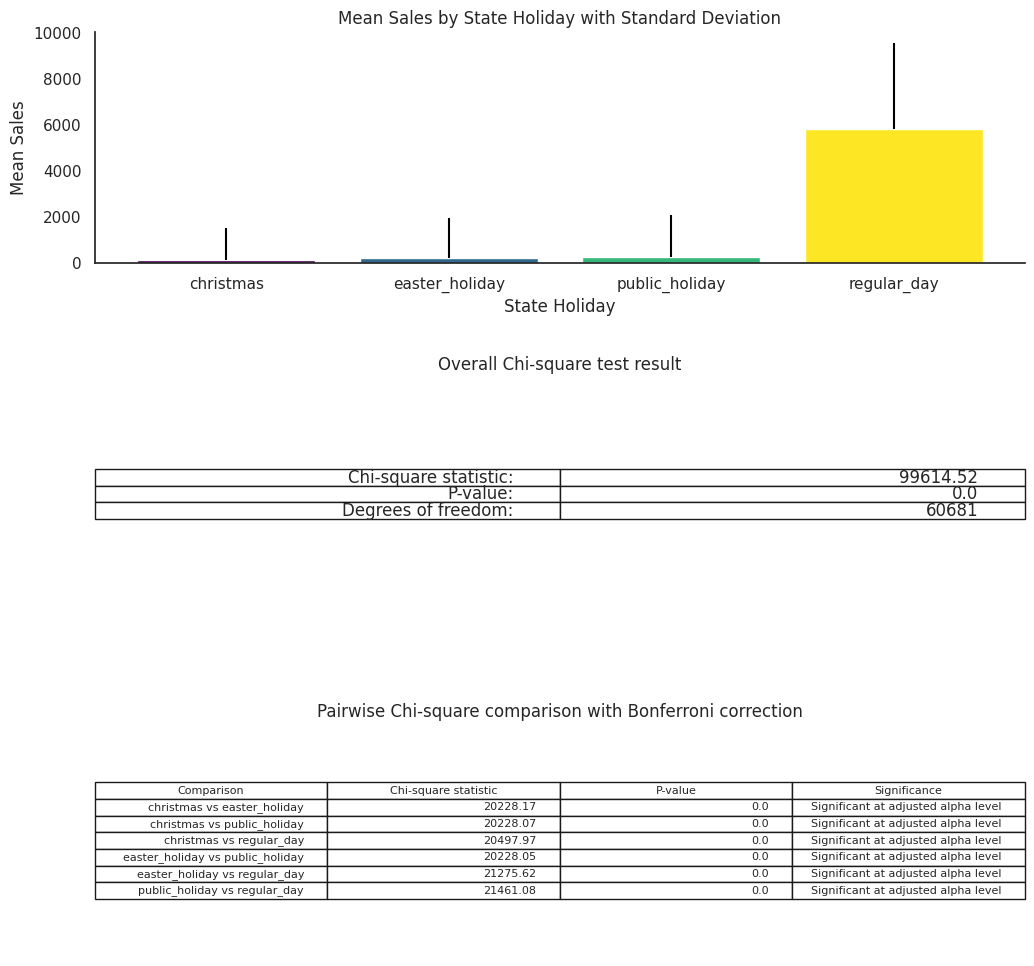

In [172]:
x2_test(X_train, 'sales','state_holiday', voi = 'Sales')

The state holiday showed a significant association with the number of sales $\chi^{2}$(60681) = 99614.52, p< 0.001. This seems to represent the fact that, based on the pairwise with Bonferroni correction comparisons, the state  holiday influences the number of customers.

Verificar lojas com menor quantidade: store type, assortment

## 2.3. Multivariate Analysis

### 2.3.1. Numerical Attributes

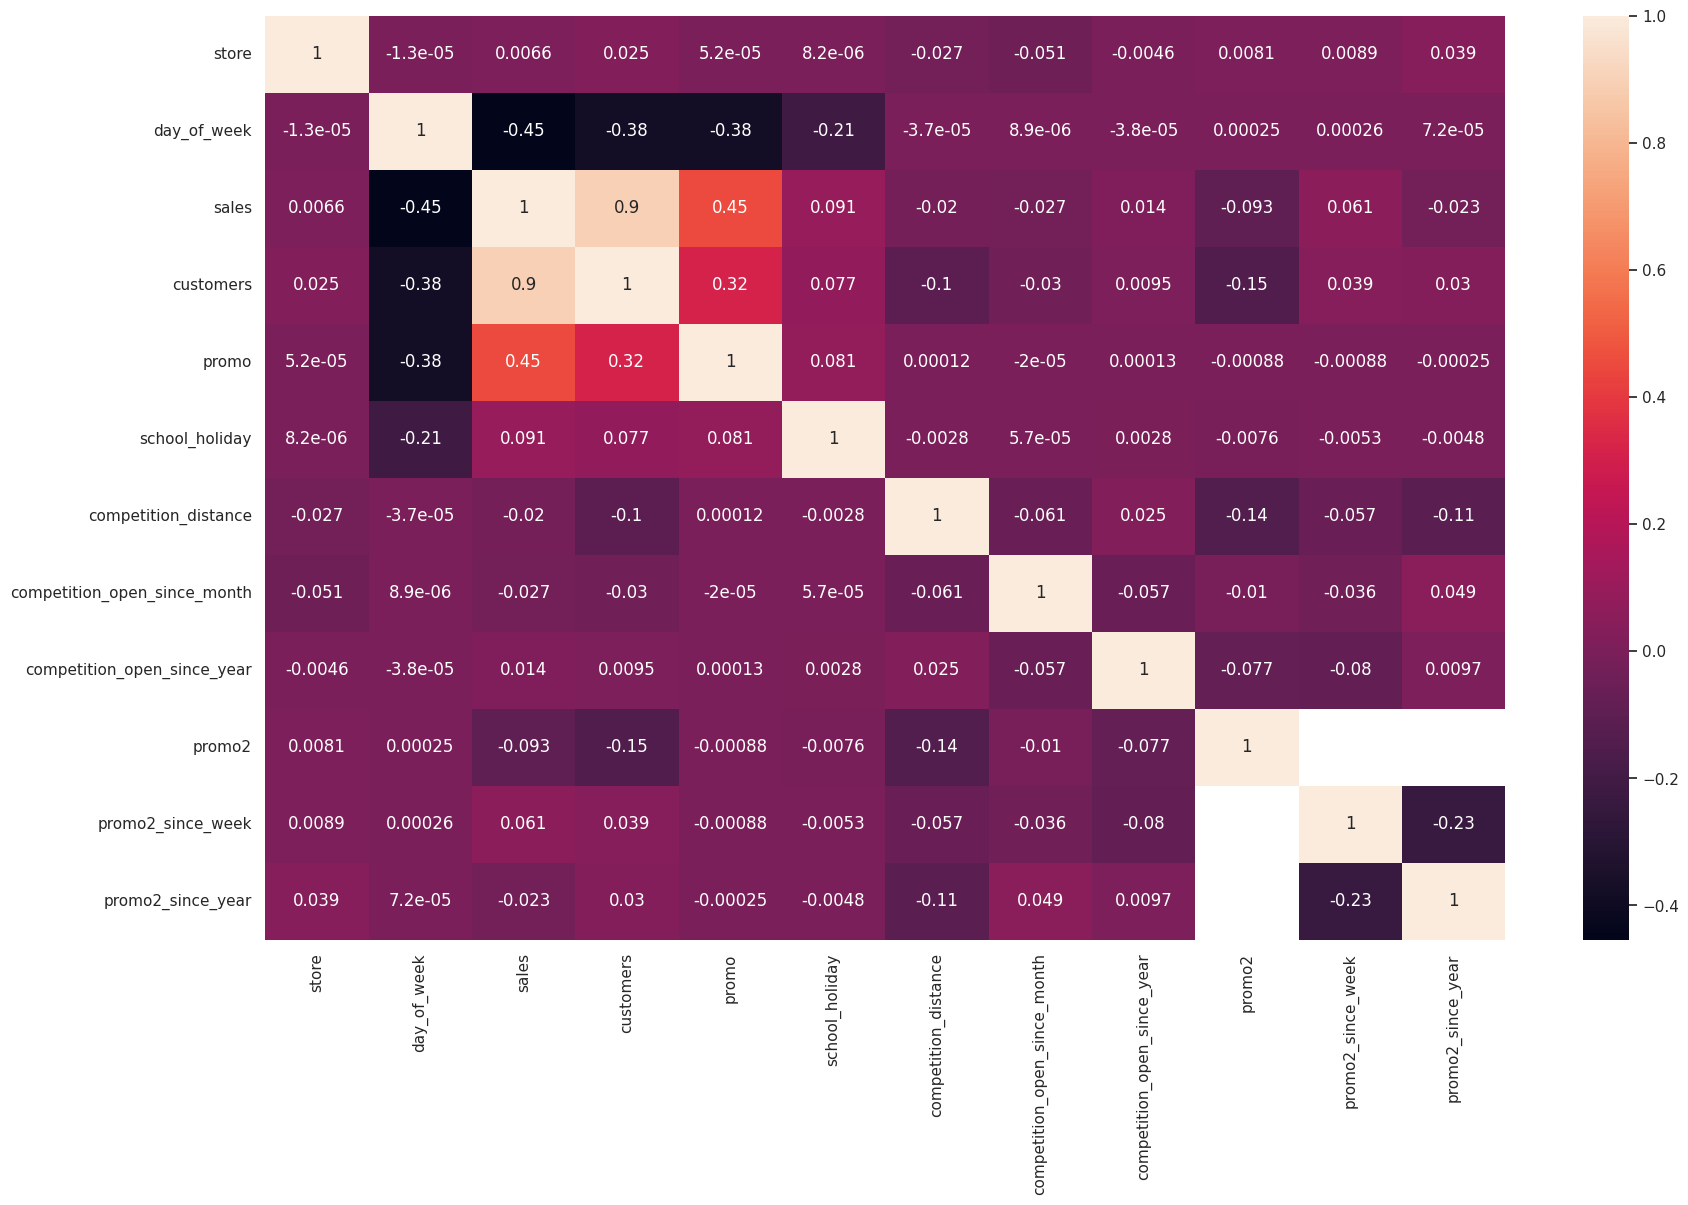

In [56]:
plt.figure(figsize=(20, 12))
num_attributes = num_attributes.drop('open', axis = 1)
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

The heatmap showed a few moderate correlations between sales and temporal variables. Such a relationship suggest both investigating and somehow expanding these temporal variables to feed the modelling in the next steps of this project.

### 2.3.2. Categorical Attributes

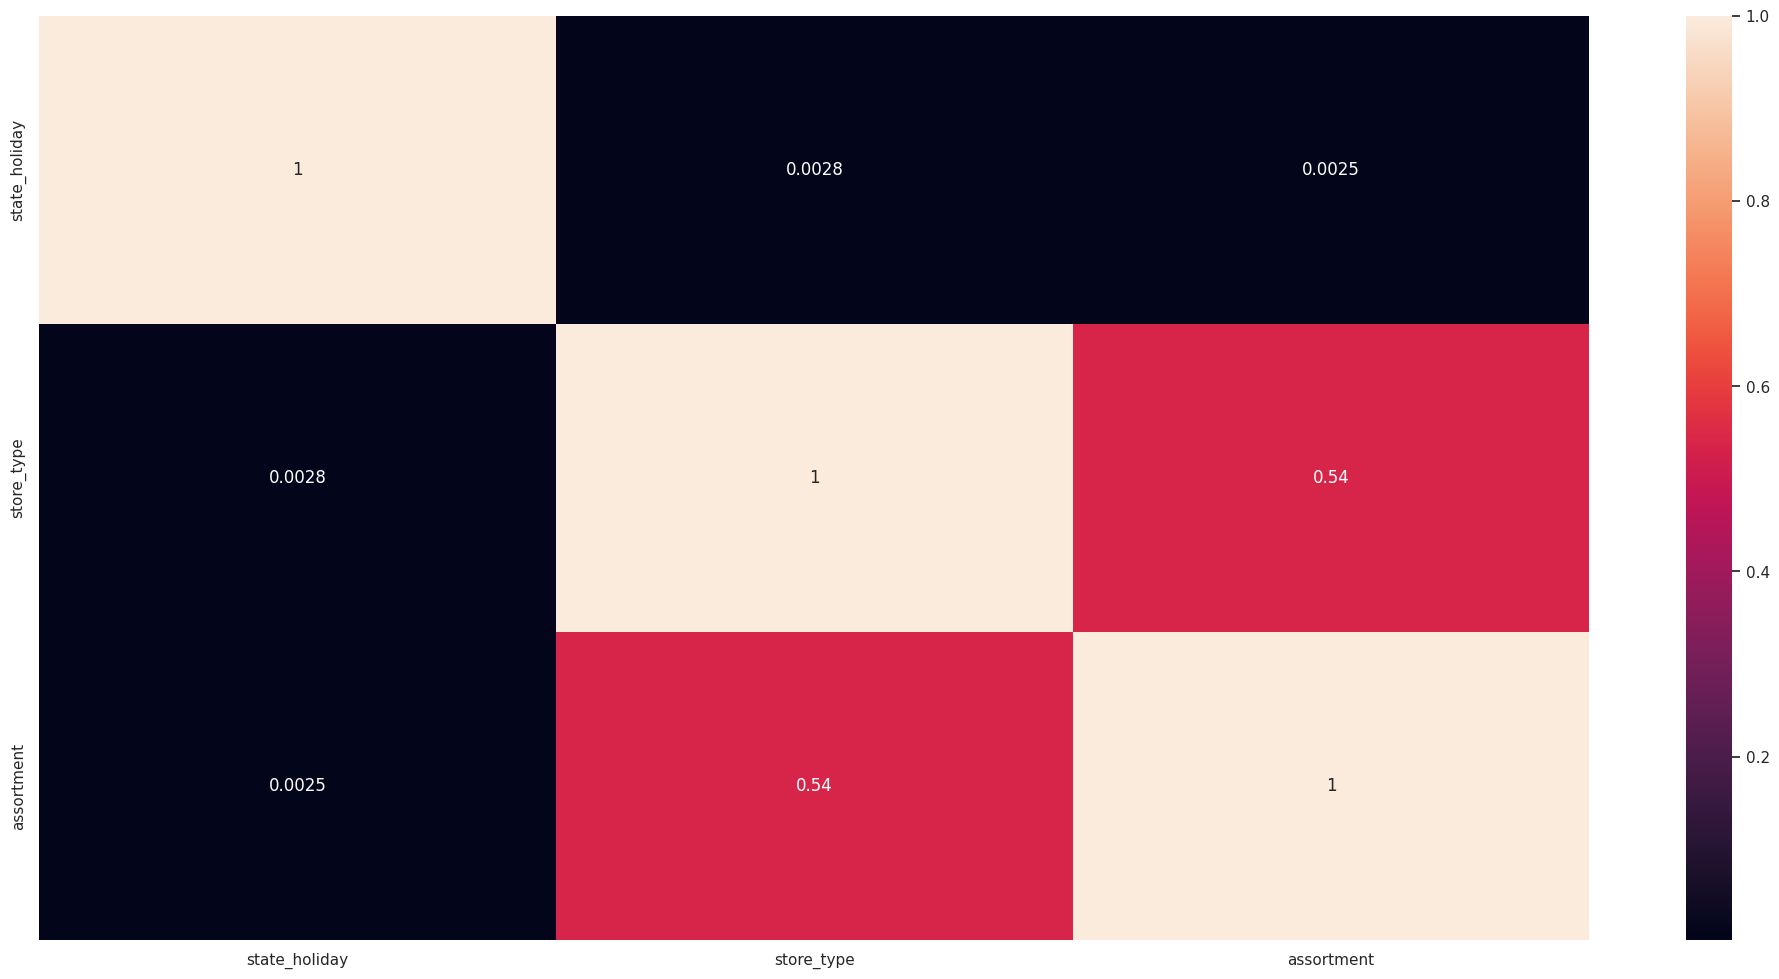

In [57]:
# Selecting categorical data
a = cat_attributes

# Calculating Cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

d = pd.DataFrame( {'state_holiday':[a1, a2, a3],
                'store_type':[a4, a5, a6],
                'assortment':[a7, a8, a9] } )

d = d.set_index( d.columns )

sns.heatmap( d, annot=True);

Additionally, the cramer's V results on the heatmap showed a large relationship between the store type and store assortment. Such a relationship also suggest these variables being important for the modelling.

# 3.0. Feature Engineering

# 4.0. Machine Learning Modeling

## 4.1. Setting up the Pipeline

### 4.1.1. Auxiliary Functions Pipeline

In [13]:
# DEFINE WORKFLOW AND FUNCTIONS FOR PIPELINE USE

# 1 - TIME ATTRIBUTES
# Step -1; Engineer time attributes
def time_attr(dataframe):
    """
    Extracts time-based attributes from a DataFrame containing a 'date' column.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing a 'date' column from which time-based attributes
        will be extracted.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with additional time-based attributes including 'year', 'month',
        'day', 'week_of_year', and 'year_week'.

    Notes:
    ------
    This function extracts various time-based attributes from a 'date' column in the
    input DataFrame, including year, month, day, week of the year, and year-week.
    The 'date' column is assumed to be in datetime format.

    Example:
    --------
    # Call the function to extract time-based attributes from the DataFrame df
    df_with_time_attrs = time_attr(df)
    """
    # Create a copy
    df = dataframe.copy()

    #Ensure th date variable is is proper format:
    df['date'] = pd.to_datetime(df['date'])

    # year
    df['year'] = df['date'].dt.year

    # month
    df['month'] = df['date'].dt.month

    # day
    df['day'] = df['date'].dt.day

    # week of year
    df['week_of_year'] = df['date'].dt.isocalendar().week

    # year week
    # df['year_week'] = df['date'].dt.strftime( '%Y-%W' )

    return df

# 2 - INPUT MISSING DATA USING kNN IMPUTER
# Step 0: Define your custom function
def data_imputer(dataframe):
    """
    Imputes missing values in specified columns of a DataFrame using KNNImputer.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing columns with missing values to be imputed.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with missing values imputed using KNNImputer.

    Notes:
    ------
    This function scans the variables to check whether they have missing values from >0 to <10%. 
    Then, it replaces missing values in the specified columns of the input DataFrame
    using KNNImputer from the scikit-learn library. It imputes missing values based on
    the k-nearest neighbors of the data points with missing values. The number of neighbors
    used for imputation is set to 5 by default.

    Example:
    --------
    # Import required libraries
    from sklearn.impute import KNNImputer
    
    # Call the function to impute missing values in the DataFrame df
    df_imputed = data_imputer(df)
    """
    df = dataframe.copy()
    # Calculate the proportion of missing values for each column
    missing_proportions = df.isna().sum() / df.shape[0] * 100

    # Initialize an empty list to store column names with more than 10% missing values
    columns_with_missing = []

    # Iterate over each column's missing proportion
    for column, proportion in missing_proportions.items():
        if proportion > 10:
            # Drop column with moe than 10% missing
            df.drop(column, axis=1, inplace=True)
        elif 0 < proportion < 10:
            columns_with_missing.append(column)

    # Initialize KNNImputer
    imputer = KNNImputer(n_neighbors=5)

    # Impute missing values
    df[columns_with_missing] = imputer.fit_transform(df[columns_with_missing])

    return df

# 3 - FORMATTING THE CATEGORICAL VARIABLES
# Step 1: Define your custom function
def cat_format(df):
    """
    Formats categorical variables in the given DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing categorical variables.

    Returns:
        pandas.DataFrame: The DataFrame with formatted categorical variables.

    Example:
        df = cat_format(df)
    
    """
    # Fix data type
    df['competition_distance'] = df['competition_distance'].astype(int)
    
    # # assortment
    df['assortment'] = df['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

    # # state holiday
    df['state_holiday'] = (
        df['state_holiday']
        .apply(
            lambda x:
                'public_holiday' 
                if x == 'a' 
                else (
                    'easter_holiday' 
                    if x == 'b' 
                    else (
                        'christmas' 
                        if x == 'c' 
                        else 'regular_day'
                    )
                ) 
        )
    )
    return df

# 4 - RESCALING
def rescaling_vars(df):
    """
    Rescales numerical variables in the given DataFrame using RobustScaler and MinMaxScaler.

    Args:
        df (pandas.DataFrame): The input DataFrame containing numerical variables.

    Returns:
        pandas.DataFrame: The DataFrame with rescaled numerical variables.

    Example:
        df = rescaling_vars(df)
    """
    rs = RobustScaler() # rescaling the variable
    mms = MinMaxScaler()

    # # year
    df['year'] = mms.fit_transform( df[['year']])
    # Check for year scaling
    return df

# 5 - TRANSFORMATION:ENCODING

def encode_vars(df):
    """
    Encodes categorical variables in the given DataFrame using different techniques.

    Args:
        df (pandas.DataFrame): The input DataFrame containing categorical variables.

    Returns:
        pandas.DataFrame: The DataFrame with encoded variables.

    Example:
        df = encode_vars(df)
    """

    le = LabelEncoder()

    # state_holiday - One Hot Encoding
    df = pd.get_dummies( df, prefix=['state_holiday'], columns = ['state_holiday'] )

    # store_type - Label Encoding ORDINAL ENCODER
    df['store_type'] = le.fit_transform( df['store_type'] ) # VERIFY
    
    # assortment - Ordinal Encoding ORDINAL ENCODER
    df['assortment_encoded'] = le.fit_transform(df['assortment'])

    return df

# 6 - LOG-TRANSFORM RESPONSE VARIABLE
def log_trf_var(df):
    """
    Applies a natural logarithm transformation (log1p) to the 'sales' column in the given DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the 'sales' column.

    Returns:
        pandas.DataFrame: The DataFrame with the transformed 'sales' column.

    Example:
        df = log_trf_var(df)
    """
    df['sales'] = np.log1p(df['sales'])

    return df


# 7 - NATURE TRANSFORMATION
def nature_transf_vars(df):
    """
    Apply trigonometric transformations to date-related columns in a DataFrame.

    Args:
        df (pandas.DataFrame): Input DataFrame containing columns 'day_of_week',
                              'month', 'day', and 'week_of_year'.

    Returns:
        pandas.DataFrame: Transformed DataFrame with additional columns:
            - 'day_of_week_sin' and 'day_of_week_cos': Sine and cosine of day of week.
            - 'month_sin' and 'month_cos': Sine and cosine of month.
            - 'day_sin' and 'day_cos': Sine and cosine of day.
            - 'week_of_year_sin' and 'week_of_year_cos': Sine and cosine of week of year.
    """
    # day of week
    df['day_of_week_sin'] = df['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
    df['day_of_week_cos'] = df['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

    # month
    df['month_sin'] = df['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
    df['month_cos'] = df['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

    # day 
    df['day_sin'] = df['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
    df['day_cos'] = df['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

    # week of year
    def weeks_in_year(year):
        if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0):
            
            return 53  # Leap year
        else:
            return 52  # Non-leap year
        
    df['week_of_year_sin'] = df['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/weeks_in_year(x) ) ) )
    df['week_of_year_cos'] = df['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/weeks_in_year(x) ) ) )

    return df

# 8 - One Hot Encoder
def ohencoder(df, cat_vars=['state_holiday','assortment','store_type']):
    """
    One-hot encodes categorical variables in a DataFrame.

    Parameters:
    -----------
    df : pandas DataFrame
        The DataFrame containing the categorical variables to be one-hot encoded.
    cat_vars : list of str, optional
        The list of column names representing categorical variables. Default is ['state_holiday', 'assortment', 'store_type'].

    Returns:
    --------
    pandas DataFrame
        The DataFrame with one-hot encoded categorical variables.

    Example:
    --------
    import pandas as pd
    from sklearn.preprocessing import OneHotEncoder
    # Sample DataFrame
    data = {'state_holiday': ['a', 'b', 'c'],
            'assortment': ['x', 'y', 'z'],
            'store_type': ['A', 'B', 'C']}
    df = pd.DataFrame(data)
    # Applying one-hot encoding
    df_encoded = ohencoder(df)
    print(df_encoded)
       state_holiday_a  state_holiday_b  state_holiday_c  assortment_x  assortment_y  assortment_z  store_type_A  store_type_B  store_type_C
    0              1.0              0.0              0.0           1.0           0.0           0.0           1.0           0.0           0.0
    1              0.0              1.0              0.0           0.0           1.0           0.0           0.0           1.0           0.0
    2              0.0              0.0              1.0           0.0           0.0           1.0           0.0           0.0           1.0
    """

    ohe = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

    ohe_data = ohe.fit_transform(df[cat_vars])

    # Create DataFrame with the one-hot encoded features and column names
    encoded_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(cat_vars), index=df.index)

    # Concatenate the encoded DataFrame with the original DataFrame
    df_encoded = pd.concat([df, encoded_df], axis=1)
    df_encoded = df_encoded.drop(df_encoded[cat_vars], axis=1)

    return df_encoded

### 4.1.2. Load and preprocess data

In [27]:
%%time
df_sales_raw = pd.read_csv( config['data']['train_path'], low_memory=False )
df_store_raw = pd.read_csv( config['data']['store_path'], low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# Rename columns

df_raw = df_raw[[   'Store','DayOfWeek', 'Date', 'Customers', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval','Sales']]

# Format column names for convenience
############INLCUIR NO YAML##################
cols_old = ['Store', 'DayOfWeek', 'Date', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval','Sales']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df_raw.columns = cols_new

# Ensure that the date variable is in a proper format
df_raw['date'] = pd.to_datetime(df_raw['date'])

# Filter out data with no sales registered

df_raw = df_raw.loc[df_raw['sales'] != 0, :] #describe the why

# df_raw1 = df_raw.copy()
# df_raw1 = df_raw1.sample(n=1500, random_state=42)
df_raw = time_attr(df_raw)
df_raw = data_imputer(df_raw)
df_raw = cat_format(df_raw)
df_raw = nature_transf_vars(df_raw)
df_raw = ohencoder(df_raw)

######################################################################
######################################################################
#######$$$ Split the dataset into train, validation, and test$$$######
######################################################################
######################################################################

# Training dataset
X_train = df_raw[df_raw['date'] <= '2014-09-10'].drop(columns=['sales', 'customers'])
y_train = df_raw.loc[df_raw['date'] <= '2014-09-10', 'sales']


# Validation dataset
X_val = df_raw[(df_raw['date'] >= '2014-09-11') & (df_raw['date'] <= '2015-06-18')].drop(columns=['sales', 'customers'])
y_val = df_raw[(df_raw['date'] >= '2014-09-11') & (df_raw['date'] <= '2015-06-18')]['sales']


# Test dataset
X_test = df_raw[df_raw['date'] >= '2015-06-19'].drop(columns=['sales', 'customers'])
y_test = df_raw[df_raw['date'] >= '2015-06-19']['sales']

X_train['date'] = X_train['date'].apply(lambda x: int(x.timestamp()))
X_val['date'] = X_val['date'].apply(lambda x: int(x.timestamp()))
X_train['date'] = X_train['date'].apply(lambda x: int(x.timestamp()))

print( f'Training Min Date: {X_train["date"].min()}')
print( f'Training Max Date: {X_train["date"].max()}')

print( f'\nValidation Min Date: {X_val["date"].min()}')
print( f'Validation Max Date: {X_val["date"].max()}')

print( f'\nTest Min Date: {X_test["date"].min()}')
print( f'Test Max Date: {X_test["date"].max()}')

print(f'X Train shape: {X_train.shape}')
print(f'y Train shape: {y_train.shape}')
print(f'X Val shape: {X_val.shape}')
print(f'y Val shape: {y_val.shape}')
print(f'X Test shape: {X_test.shape}')
print(f'y Test shape: {y_test.shape}')

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2014-09-10 00:00:00

Validation Min Date: 2014-09-11 00:00:00
Validation Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00
X Train shape: (561576, 31)
y Train shape: (561576,)
X Val shape: (241366, 31)
y Val shape: (241366,)
X Test shape: (41396, 31)
y Test shape: (41396,)
CPU times: user 2min 12s, sys: 46.2 s, total: 2min 58s
Wall time: 1min 30s


In [24]:
print(X_train.columns)
print(X_val.columns)
print(X_test.columns)

Index(['store', 'day_of_week', 'date', 'open', 'promo', 'school_holiday',
       'competition_distance', 'promo2', 'year', 'month', 'day',
       'week_of_year', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'assortment_basic', 'assortment_extended',
       'assortment_extra', 'store_type_a', 'store_type_b', 'store_type_c',
       'store_type_d'],
      dtype='object')
Index(['store', 'day_of_week', 'date', 'open', 'promo', 'school_holiday',
       'competition_distance', 'promo2', 'year', 'month', 'day',
       'week_of_year', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',


### 4.1.3. Feature Selection Boruta

In [25]:
#Feature selection using Boruta algorithm on train data only

# Makin a copy of X_train
X_train_numeric = X_train.copy()

# Convert Timestamp columns to numerical representation
timestamp_columns = X_train.select_dtypes(include=['datetime64']).columns
for col in timestamp_columns:
    X_train_numeric[col] = (X_train[col] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')


rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs = -1)
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2)
boruta_selector.fit_transform(X_train_numeric.values, y_train.values)

selected_features = X_train_numeric.columns[boruta_selector.support_]

fs = selected_features.to_list()
fs

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	31
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	20
Tentative: 	0
Rejected: 	11


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	20
Tentative: 	0
Rejected: 	11


['store',
 'day_of_week',
 'date',
 'promo',
 'competition_distance',
 'promo2',
 'month',
 'day',
 'week_of_year',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'assortment_basic',
 'assortment_extended',
 'assortment_extra',
 'store_type_b']

In [15]:
# Boruta Feature selected
fs = [  'store',
        'day_of_week',
        'date',
        'promo',
        'competition_distance',
        'promo2',
        'month',
        'day',
        'week_of_year',
        'day_of_week_sin',
        'day_of_week_cos',
        'month_cos',
        'day_sin',
        'day_cos',
        'week_of_year_sin',
        'week_of_year_cos',
        'assortment_basic',
        'assortment_extended',
        'assortment_extra',
        'store_type_b'  ]

## 4.2. Linear Regression Model

In [31]:
# Define variables to preprocess
numerical_features = [
 'competition_distance',
 ]

# Create preprocesssing pipeline

numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        
    ])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['competition_distance'])])

In [32]:
def random_search_with_metrics(model, model_name, X_train, y_train, X_val, y_val, preprocessor, fs):
    param_distributions = {
        'regressor__fit_intercept': [True, False],
        }

    regressor = model

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    tscv = TimeSeriesSplit(n_splits=5)
    
    results = []

    for train_index, val_index in tscv.split(X_train):
        # Cloning the pipeline to ensure a fresh model for each iteration
        pipeline_cloned = clone(pipeline)
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        random_search = RandomizedSearchCV(pipeline_cloned, param_distributions, n_iter=2, cv=tscv, scoring='neg_mean_squared_error', random_state=42)
        random_search.fit(X_train_fold[fs], y_train_fold)

        best_model = random_search.best_estimator_

        y_val_pred = best_model.predict(X_val_fold[fs])
        val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        val_mae = mean_absolute_error(y_val_fold, y_val_pred)
        val_mape = mean_absolute_error(y_val_fold, y_val_pred) / y_val_fold.mean()

        results.append({
            'Validation RMSE': val_rmse,
            'Validation MAE': val_mae,
            'Validation MAPE': val_mape,
        })

    results_df = pd.DataFrame(results)

    metrics_mean = results_df.mean()
    metrics_std = results_df.std()

    summary_df = pd.DataFrame({
        'Model': model_name,
        'Metric': metrics_mean.index,
        'Mean': metrics_mean.values,
        'Standard Deviation': metrics_std.values
    })

    return summary_df, random_search

# Run modeling with random search cross-validation for Linear Regression
summary_df_lr, random_search = random_search_with_metrics(LinearRegression(n_jobs=-1), "Linear Regression", X_train, y_train, X_val, y_val, preprocessor, fs)

In [33]:
summary_df_lr

,Model,Metric,Mean,Standard Deviation
0,Linear Regression,Validation RMSE,3083.627426,218.172440
1,Linear Regression,Validation MAE,2296.479790,101.138755
2,Linear Regression,Validation MAPE,0.337093,0.007551


In [34]:
print(f'Best parameters found:{random_search.best_params_}\n Best model found: {random_search.best_estimator_}')

Best parameters found:{'regressor__fit_intercept': True}
 Best model found: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['competition_distance'])])),
                ('regressor', LinearRegression(n_jobs=-1))])


## 4.3. Linear Regression Regularized Model - Lasso

In [35]:
# Define variables to preprocess
numerical_features = [
 'competition_distance',
 ]

# Create preprocesssing pipeline

numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        
    ])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['competition_distance'])])

In [36]:
def random_search_with_metrics(model, model_name, X_train, y_train, X_val, y_val, preprocessor, fs):
    param_distributions = {
        'regressor__alpha': [0.001, 0.01, 0.1, 1.0],
        'regressor__fit_intercept': [True, False],
        }

    regressor = model

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    tscv = TimeSeriesSplit(n_splits=5)
    
    results = []

    for train_index, val_index in tscv.split(X_train):
        # Cloning the pipeline to ensure a fresh model for each iteration
        pipeline_cloned = clone(pipeline)
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        random_search = RandomizedSearchCV(pipeline_cloned, param_distributions, n_iter=4, cv=tscv, scoring='neg_mean_squared_error', random_state=42)
        random_search.fit(X_train_fold[fs], y_train_fold)

        best_model = random_search.best_estimator_

        y_val_pred = best_model.predict(X_val_fold[fs])
        val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        val_mae = mean_absolute_error(y_val_fold, y_val_pred)
        val_mape = mean_absolute_error(y_val_fold, y_val_pred) / y_val_fold.mean()

        results.append({
            'Model':model_name,
            'Validation RMSE': val_rmse,
            'Validation MAE': val_mae,
            'Validation MAPE': val_mape,
        })

    results_df = pd.DataFrame(results)

    metrics_mean = results_df.select_dtypes(include=[int, float]).mean()
    metrics_std = results_df.select_dtypes(include=[int, float]).std()

    summary_df = pd.DataFrame({
        'Model': model_name,
        'Metric': metrics_mean.index,
        'Mean': metrics_mean.values,
        'Standard Deviation': metrics_std.values
    })

    return summary_df, random_search

# Run modeling with random search cross-validation for Lasso Regression
summary_df_lasso, random_search = random_search_with_metrics(Lasso(), "Lasso Regression", X_train, y_train, X_val, y_val, preprocessor, fs)


In [37]:
summary_df_lasso

,Model,Metric,Mean,Standard Deviation
0,Lasso Regression,Validation RMSE,3083.627567,218.172422
1,Lasso Regression,Validation MAE,2296.479702,101.138727
2,Lasso Regression,Validation MAPE,0.337093,0.007551


In [19]:
summary_df_lasso

,Model,Metric,Mean,Standard Deviation
0,Lasso Regression,Validation RMSE,1702.390804,124.609553
1,Lasso Regression,Validation MAE,1232.412945,72.118754
2,Lasso Regression,Validation MAPE,0.180808,0.004660


In [38]:
print(f'Best parameters found:{random_search.best_params_}\n Best model found: {random_search.best_estimator_}')

Best parameters found:{'regressor__fit_intercept': True, 'regressor__alpha': 0.001}
 Best model found: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['competition_distance'])])),
                ('regressor', Lasso(alpha=0.001))])


## 4.4. Random Forest Regressor

In [39]:
# Define variables to preprocess
numerical_features = [
  'competition_distance',
 ]

# Create preprocesssing pipeline

numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        
    ])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['competition_distance'])])

In [40]:
def random_search_with_metrics(model_name, X_train, y_train, X_val, y_val, preprocessor, fs):
    param_distributions = {
        'regressor__n_estimators': [25, 50, 100, 150],
        'regressor__max_depth': [5, 10, 15, 45]
    }

    regressor = RandomForestRegressor(n_jobs=-1)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    tscv = TimeSeriesSplit(n_splits=5)
    
    results = []

    for train_index, val_index in tscv.split(X_train):
        # Clone the pipeline to ensure a fresh model for each iteration
        pipeline_cloned = clone(pipeline)
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        random_search = RandomizedSearchCV(pipeline_cloned, param_distributions, n_iter=10, cv=tscv, scoring='neg_mean_squared_error', random_state=42)
        random_search.fit(X_train_fold[fs], y_train_fold)

        best_model = random_search.best_estimator_

        y_val_pred = best_model.predict(X_val_fold[fs])
        val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        val_mae = mean_absolute_error(y_val_fold, y_val_pred)
        val_mape = mean_absolute_error(y_val_fold, y_val_pred) / y_val_fold.mean()

        results.append({
            'Model': model_name,
            'Validation RMSE': val_rmse,
            'Validation MAE': val_mae,
            'Validation MAPE': val_mape,
        })

    results_df = pd.DataFrame(results)

    metrics_mean = results_df.select_dtypes(include=[int,float]).mean()
    metrics_std = results_df.select_dtypes(include=[int,float]).std()

    summary_df = pd.DataFrame({
        'Model': model_name,
        'Metric': metrics_mean.index,
        'Mean': metrics_mean.values,
        'Standard Deviation': metrics_std.values
    })

    return summary_df, random_search

# # Run modeling with random search cross-validation for Random Forest
summary_df_rf, random_search = random_search_with_metrics("Random Forest", X_train, y_train, X_val, y_val, preprocessor, fs)


In [41]:
summary_df_rf['Model'] = "Random Forest"
summary_df_rf = summary_df_rf[['Model','Metric','Mean','Standard Deviation']]

In [42]:
summary_df_rf

,Model,Metric,Mean,Standard Deviation
0,Random Forest,Validation RMSE,2581.001385,226.597102
1,Random Forest,Validation MAE,1883.523517,119.003144
2,Random Forest,Validation MAPE,0.276316,0.008774


In [24]:
summary_df_rf

,Model,Metric,Mean,Standard Deviation
0,Random Forest,Validation RMSE,1079.110899,108.753133
1,Random Forest,Validation MAE,708.754118,57.329059
2,Random Forest,Validation MAPE,0.103909,0.004505


In [43]:
print(f"Best parameters found: {random_search.best_params_}\nBest model found: {random_search.best_estimator_}")

Best parameters found: {'regressor__n_estimators': 50, 'regressor__max_depth': 45}
Best model found: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['competition_distance'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=45, n_estimators=50,
                                       n_jobs=-1))])


Best parameters found:  {'regressor__max_depth': 45, 'regressor__n_estimators': 150}  
Best parameters found:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['customers',
                                                   'competition_distance'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=45, n_estimators=150))])

## 4.5. XGBoost Regressor

In [31]:
# Define variables to preprocess
numerical_features = [
 'competition_distance',
 ]

# Create preprocesssing pipeline

numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        
    ])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['competition_distance'])])

In [32]:
def random_search_with_metrics(model_name, X_train, y_train, X_val, y_val, preprocessor, fs):
    param_distributions = {
        'regressor__n_estimators': [1500, 1700, 2500, 3000, 3500],
        'regressor__eta': [0.01, 0.03],
        'regressor__max_depth': [3, 5, 9],
        'regressor__subsample': [0.1, 0.3, 0.7],
        'regressor__colsample_bytree': [0.3, 0.7, 0.9],
        'regressor__learning_rate': [0.1, 0.01, 0.001],
        'regressor__min_child_weight': [3, 8, 15]
    }

    regressor = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    tscv = TimeSeriesSplit(n_splits=5)
    
    results = []

    for train_index, val_index in tscv.split(X_train):
        # Clone the pipeline to ensure a fresh model for each iteration
        pipeline_cloned = clone(pipeline)
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        random_search = RandomizedSearchCV(pipeline_cloned, param_distributions, n_iter=10, cv=tscv, scoring='neg_mean_squared_error', random_state=42)
        random_search.fit(X_train_fold[fs], y_train_fold)

        best_model = random_search.best_estimator_

        y_val_pred = best_model.predict(X_val_fold[fs])
        val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        val_mae = mean_absolute_error(y_val_fold, y_val_pred)
        val_mape = mean_absolute_error(y_val_fold, y_val_pred) / y_val_fold.mean()

        results.append({
            'Validation RMSE': val_rmse,
            'Validation MAE': val_mae,
            'Validation MAPE': val_mape,
        })

    results_df = pd.DataFrame(results)

    metrics_mean = results_df.mean()
    metrics_std = results_df.std()

    summary_df = pd.DataFrame({
        'Model': model_name,
        'Metric': metrics_mean.index,
        'Mean': metrics_mean.values,
        'Standard Deviation': metrics_std.values
    })

    return summary_df, random_search

# Run modeling with random search cross-validation for XGBoost
summary_df_xgb, random_search = random_search_with_metrics("XGBoost", X_train, y_train, X_val, y_val, preprocessor, fs)


In [46]:
summary_df_xgb

,Model,Metric,Mean,Standard Deviation
0,XGBoost,Validation RMSE,2857.091929,208.875326
1,XGBoost,Validation MAE,2139.696189,100.577324
2,XGBoost,Validation MAPE,0.314045,0.006963


In [28]:
summary_df_xgb

,Model,Metric,Mean,Standard Deviation
0,XGBoost,Validation RMSE,1171.468488,107.001142
1,XGBoost,Validation MAE,840.394283,50.487586
2,XGBoost,Validation MAPE,0.123301,0.003823


In [33]:
print(f'Best parameters found:{random_search.best_params_}\n Best model found:{random_search.best_estimator_}')

Best parameters found:{'regressor__subsample': 0.3, 'regressor__n_estimators': 1700, 'regressor__min_child_weight': 15, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__eta': 0.03, 'regressor__colsample_bytree': 0.7}
 Best model found:Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['competition_distance'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.7, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eta=0.03,
                              eval_m

## 4.6. Comparing Models

In [48]:
summ_models = pd.concat([summary_df_lr, summary_df_lasso, summary_df_rf, summary_df_xgb])
summ_models

,Model,Metric,Mean,Standard Deviation
0,Linear Regression,Validation RMSE,3083.627426,218.172440
1,Linear Regression,Validation MAE,2296.479790,101.138755
2,Linear Regression,Validation MAPE,0.337093,0.007551
0,Lasso Regression,Validation RMSE,3083.627567,218.172422
1,Lasso Regression,Validation MAE,2296.479702,101.138727
2,Lasso Regression,Validation MAPE,0.337093,0.007551
0,Random Forest,Validation RMSE,2581.001385,226.597102
1,Random Forest,Validation MAE,1883.523517,119.003144
2,Random Forest,Validation MAPE,0.276316,0.008774
0,XGBoost,Validation RMSE,2857.091929,208.875326


In [49]:
summ_models.to_csv('../data/summ_models.csv', index=False)

## 4.7. Final Model

In [28]:
import datetime as dt
X_test['date'] = X_test['date'].apply(lambda x: int(x.timestamp()))
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41396 entries, 0 to 47944
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   store                         41396 non-null  int64  
 1   day_of_week                   41396 non-null  int64  
 2   date                          41396 non-null  int64  
 3   open                          41396 non-null  int64  
 4   promo                         41396 non-null  int64  
 5   school_holiday                41396 non-null  int64  
 6   competition_distance          41396 non-null  int64  
 7   promo2                        41396 non-null  int64  
 8   year                          41396 non-null  int32  
 9   month                         41396 non-null  int32  
 10  day                           41396 non-null  int32  
 11  week_of_year                  41396 non-null  UInt32 
 12  day_of_week_sin               41396 non-null  float64
 13  day_of

In [29]:
import datetime as dt
X_train['date'] = X_train['date'].apply(lambda x: int(x.timestamp()))
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 561576 entries, 341100 to 1017190
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   store                         561576 non-null  int64  
 1   day_of_week                   561576 non-null  int64  
 2   date                          561576 non-null  int64  
 3   open                          561576 non-null  int64  
 4   promo                         561576 non-null  int64  
 5   school_holiday                561576 non-null  int64  
 6   competition_distance          561576 non-null  int64  
 7   promo2                        561576 non-null  int64  
 8   year                          561576 non-null  int32  
 9   month                         561576 non-null  int32  
 10  day                           561576 non-null  int32  
 11  week_of_year                  561576 non-null  UInt32 
 12  day_of_week_sin               561576 non-nu

Best parameters found:{'regressor__subsample': 0.3, 'regressor__n_estimators': 1700, 'regressor__min_child_weight': 15, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__eta': 0.03, 'regressor__colsample_bytree': 0.7}
 

In [35]:
param_tuned = {
    'n_estimators': 1700,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 15, 
    'learning_rate': 0.1,
        }

In [36]:
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    learning_rate=param_tuned['learning_rate'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit(X_train[fs], y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( X_test[fs] )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor',  y_test, yhat_xgb_tuned )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,839.844514,0.127926,1227.657853


# 5.0. Translating and Interpreting Error

In [37]:
df = X_test.copy()

df['sales'] = y_test
df['predictions'] = yhat_xgb_tuned
df.columns

Index(['store', 'day_of_week', 'date', 'open', 'promo', 'school_holiday',
       'competition_distance', 'promo2', 'year', 'month', 'day',
       'week_of_year', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos', 'state_holiday_christmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'assortment_basic', 'assortment_extended',
       'assortment_extra', 'store_type_a', 'store_type_b', 'store_type_c',
       'store_type_d', 'sales', 'predictions'],
      dtype='object')

## 5.1. Business Performance

In [38]:
# sum of predictions
df91 = df[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

/tmp/ipykernel_62716/442976351.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df9_aux1 = df[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
/tmp/ipykernel_62716/442976351.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df9_aux2 = df[['store', 'sales', 'predictions']].groupby( 'store

In [39]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1109,1110,456829.250000,448938.161951,464720.338049,7891.088049,1.906754
763,764,228290.671875,226133.789003,230447.554747,2156.882872,0.580352
291,292,104129.679688,100784.297556,107475.061819,3345.382131,0.563214
27,28,242844.640625,240901.461083,244787.820167,1943.179542,0.552301
838,839,206328.140625,204498.974689,208157.306561,1829.165936,0.537528


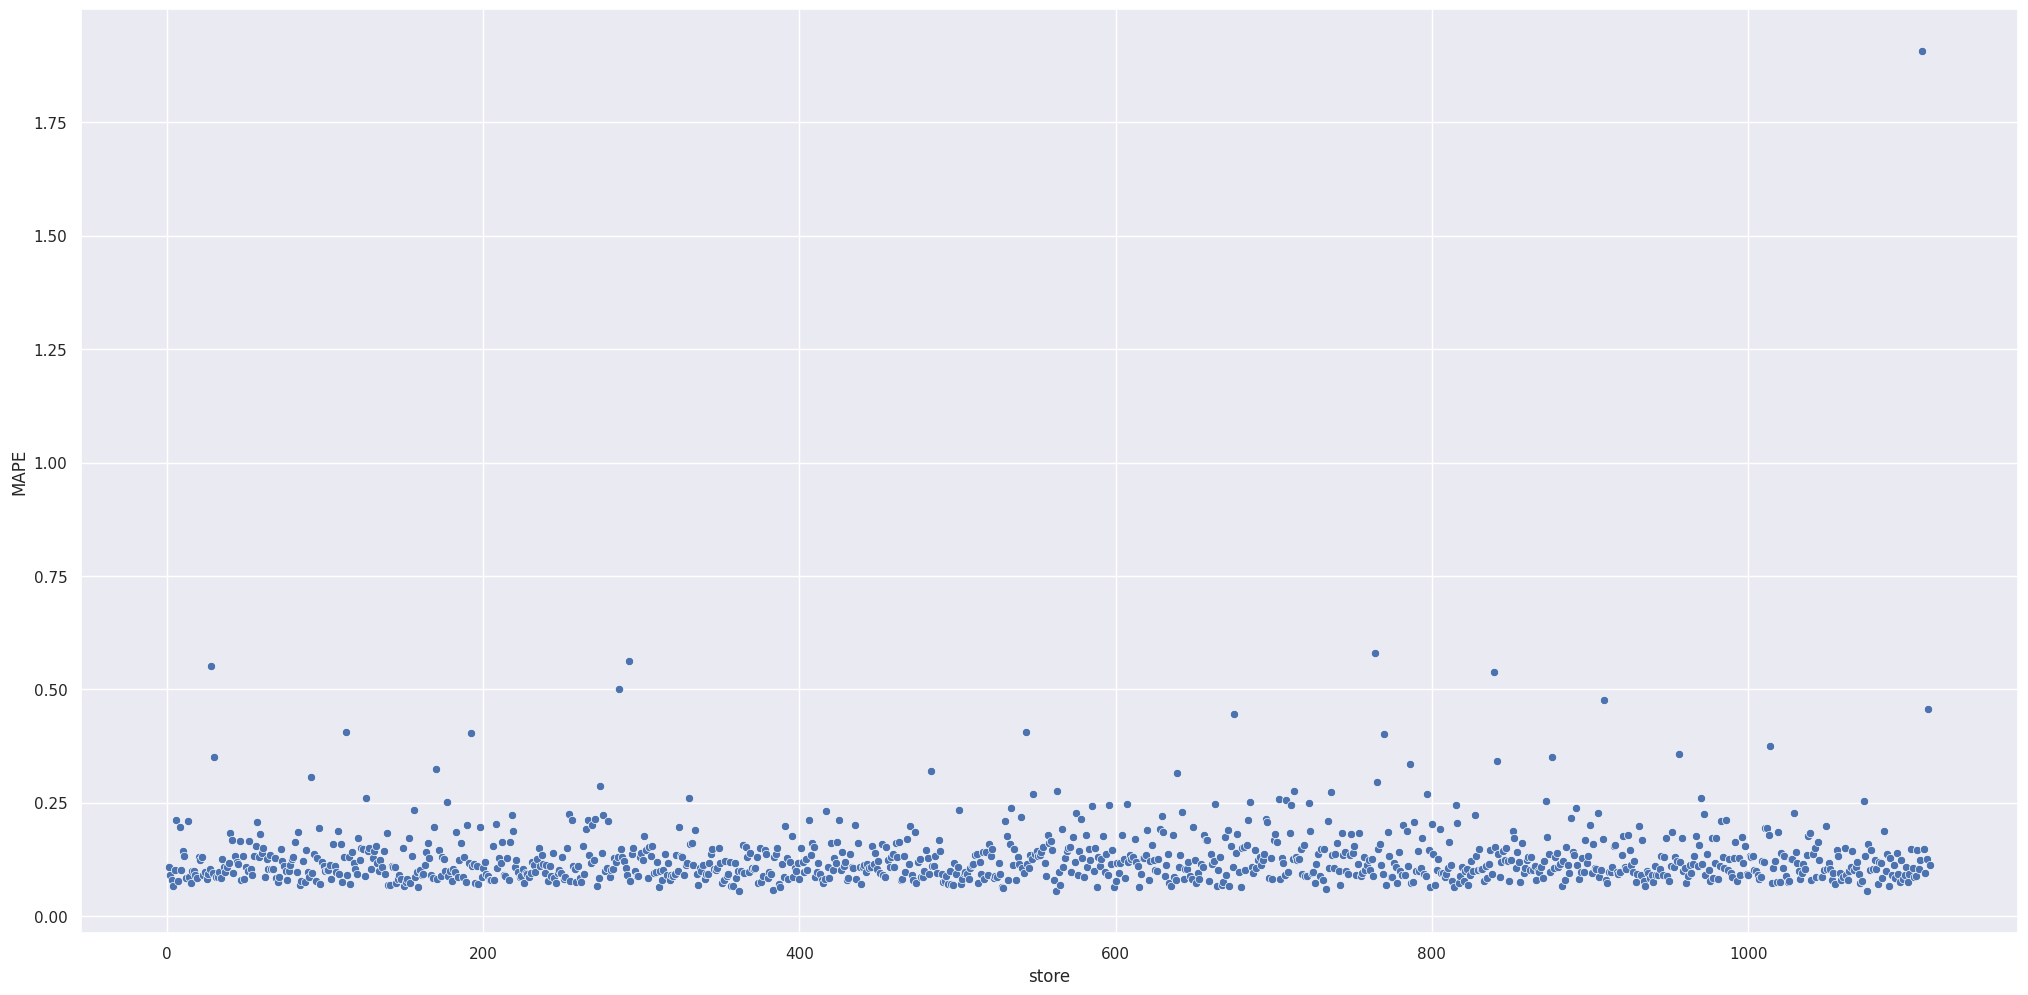

In [40]:
sns.scatterplot( x='store', y='MAPE', data=df92 )
sns.set_style(style='white')

## 5.2. Overall Performance

In [41]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$283,175,936.00"
1,worst_scenario,"R$282,235,542.04"
2,best_scenario,"R$284,116,287.79"


## 5.3. Machine Learning Performance

In [42]:
df['error'] = df['sales'] - df['predictions']
df['error_rate'] = df['predictions'] / df['sales']

/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/thiago/.pyenv/versions/3.10.4/envs/ds_prod/lib/python3.10/site-packages/seaborn/_oldcore.py

<Axes: xlabel='predictions', ylabel='error'>

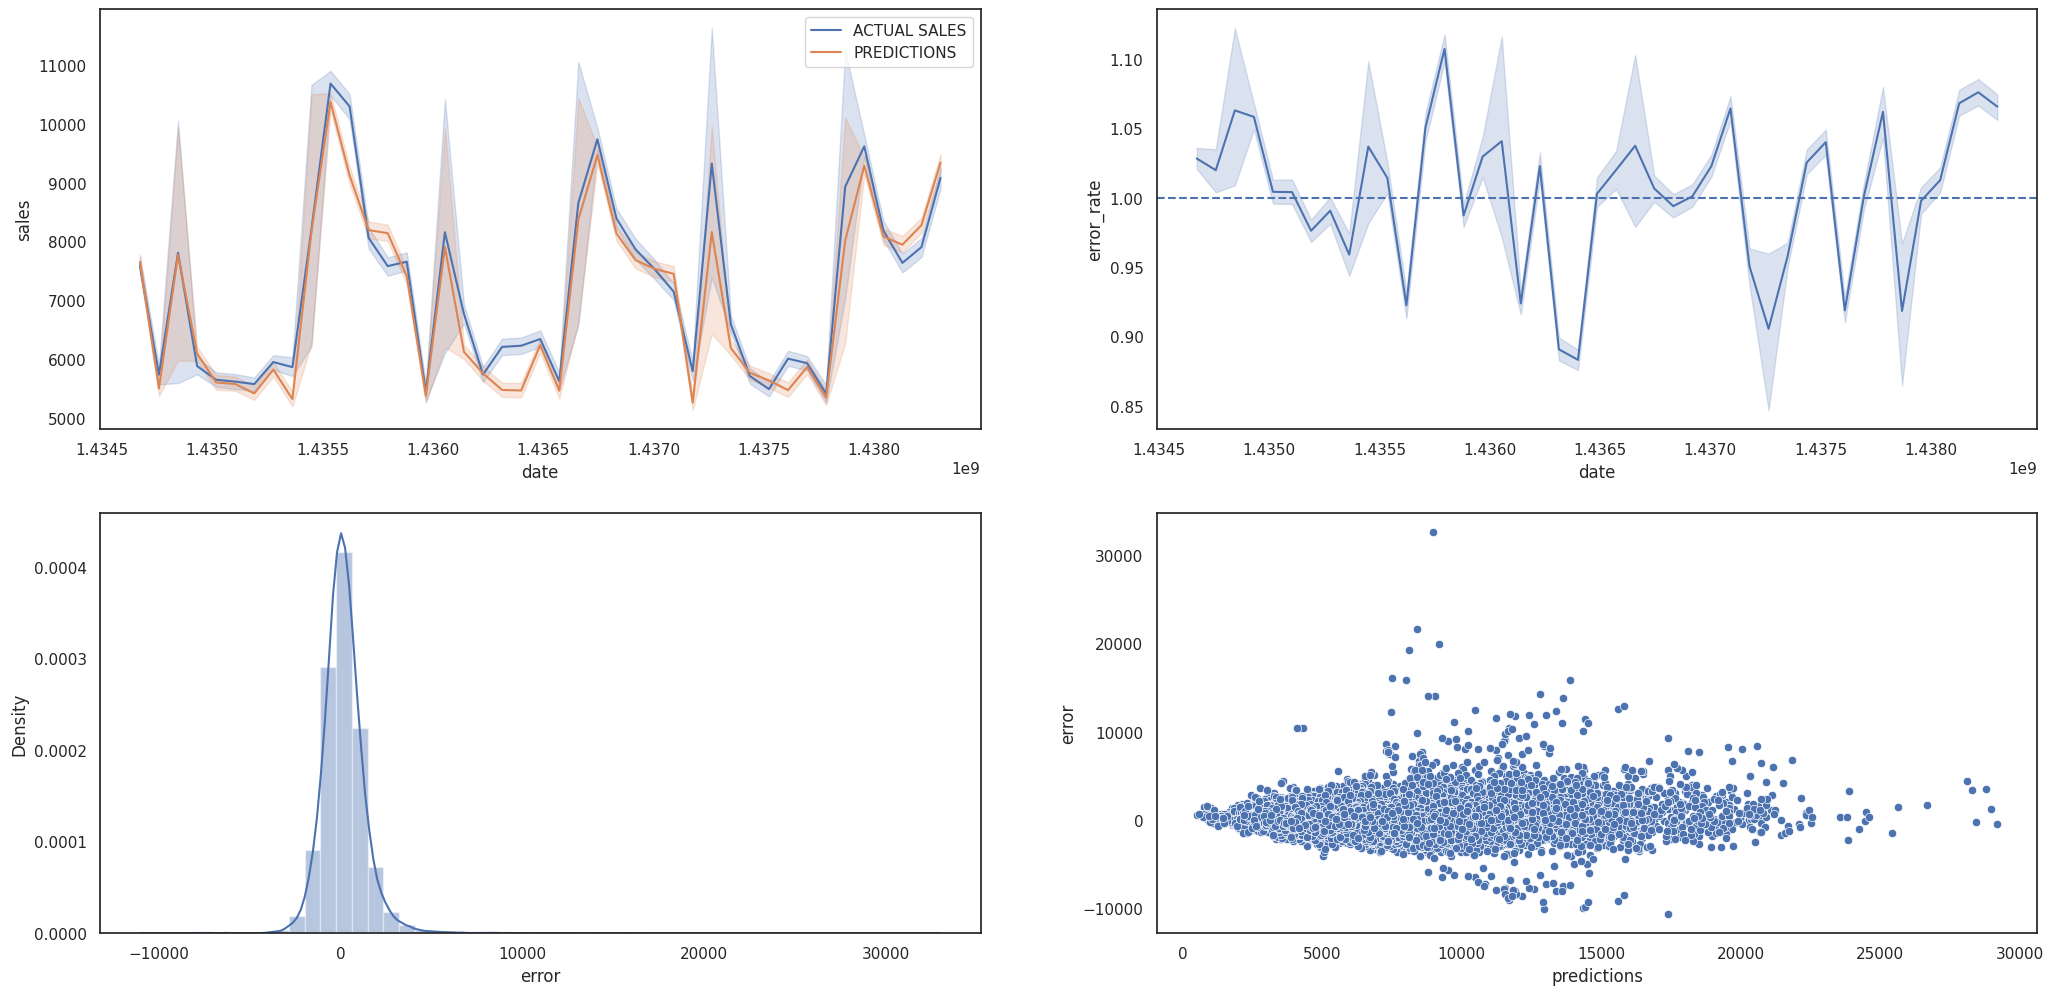

In [43]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df, label='ACTUAL SALES' )
sns.lineplot( x='date', y='predictions', data=df, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( x='predictions', y='error', data=df )

# 6.0. Deploy Model to Production

In [59]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( '../model/model_rossmann.pkl', 'wb' ) )

## 6.1. DS Prod Class

In [ ]:
import inflection
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder


class DSProd( object ):
    """
    Class for data preprocessing and feature engineering for a machine learning prediction project.
    """

    def __init__(self):
        """
        Initialize DSProd object.
        """
        pass

    def data_cleaning(self, df):
        """
        Clean the input DataFrame by formatting column names and removing rows with zero sales.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input DataFrame to be cleaned.

        Returns:
        --------
        pandas.DataFrame
            Cleaned DataFrame.
        """

        # Format column names for convenience
        cols_old = ['Store'              ,'DayOfWeek'                ,'Date'                    ,
                    'Customers'          ,'Open'                     ,'Promo', 'StateHoliday'   ,
                    'SchoolHoliday'      ,'StoreType'                ,'Assortment'              ,
                    'CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
                    'Promo2'             ,'Promo2SinceWeek'          ,'Promo2SinceYear'         ,
                    'PromoInterval'      ,'Sales']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df.columns = cols_new

        # Ensure that the date variable is in a proper format
        df['date'] = pd.to_datetime(df['date'])

        # Filter out data with no sales registered
        df = df.loc[df['sales'] != 0, :]

        return df


    def time_attributes(self, df):
        """
        Extracts time-based attributes from a DataFrame containing a 'date' column.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input DataFrame containing a 'date' column from which time-based attributes
            will be extracted.

        Returns:
        --------
        pandas.DataFrame
            DataFrame with additional time-based attributes including 'year', 'month',
            'day', 'week_of_year', and 'year_week'.

        Notes:
        ------
        This function extracts various time-based attributes from a 'date' column in the
        input DataFrame, including year, month, day, week of the year, and year-week.
        The 'date' column is assumed to be in datetime format.

        Example:
        --------
        # Call the function to extract time-based attributes from the DataFrame df
        df_with_time_attrs = time_attr(df)
        """
        #Ensure th date variable is is proper format:
        df['date'] = pd.to_datetime(df['date'])

        # year
        df['year'] = df['date'].dt.year

        # month
        df['month'] = df['date'].dt.month

        # day
        df['day'] = df['date'].dt.day

        # week of year
        df['week_of_year'] = df['date'].dt.isocalendar().week

        return df


    def data_imputer(self, df):
        """
        Imputes missing values in specified columns of a DataFrame using KNNImputer.

        Parameters:
        -----------
        df : pandas.DataFrame
            Input DataFrame containing columns with missing values to be imputed.

        Returns:
        --------
        pandas.DataFrame
            DataFrame with missing values imputed using KNNImputer.

        Notes:
        ------
        This function scans the variables to check whether they have missing values from >0 to <10%. 
        Then, it replaces missing values in the specified columns of the input DataFrame
        using KNNImputer from the scikit-learn library. It imputes missing values based on
        the k-nearest neighbors of the data points with missing values. The number of neighbors
        used for imputation is set to 5 by default.

        Example:
        --------
        # Import required libraries
        from sklearn.impute import KNNImputer

        # Call the function to impute missing values in the DataFrame df
        df_imputed = data_imputer(df)
        """
        # Calculate the proportion of missing values for each column
        missing_proportions = df.isna().sum() / df.shape[0] * 100

        # Initialize an empty list to store column names with more than 10% missing values
        columns_with_missing = []

        # Iterate over each column's missing proportion
        for column, proportion in missing_proportions.items():
            if proportion > 10:
                # Drop column with moe than 10% missing
                df.drop(column, axis=1, inplace=True)
            elif 0 < proportion < 10:
                columns_with_missing.append(column)

        # Initialize KNNImputer
        imputer = KNNImputer(n_neighbors=5)

        # Impute missing values
        df[columns_with_missing] = imputer.fit_transform(df[columns_with_missing])

        return df

    def categorical_format(self, df):
        """
        Formats categorical variables in the given DataFrame.

        Args:
            df (pandas.DataFrame): The input DataFrame containing categorical variables.

        Returns:
            pandas.DataFrame: The DataFrame with formatted categorical variables.

        Example:
            df = cat_format(df)

        """
        # Fix data type
        df['competition_distance'] = df['competition_distance'].astype(int)

        # # assortment
        df['assortment'] = df['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # # state holiday
        df['state_holiday'] = df['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        return df

    def rescaling_vars(self, df):
        """
        Rescales numerical variables in the given DataFrame using RobustScaler and MinMaxScaler.

        Args:
            df (pandas.DataFrame): The input DataFrame containing numerical variables.

        Returns:
            pandas.DataFrame: The DataFrame with rescaled numerical variables.

        Example:
            df = rescaling_vars(df)
        """
        mms = MinMaxScaler()

        # # year
        df['year'] = mms.fit_transform( df[['year']])

        return df

    def encode_vars(self, df):
        """
        Encodes categorical variables in the given DataFrame using different techniques.

        Args:
            df (pandas.DataFrame): The input DataFrame containing categorical variables.

        Returns:
            pandas.DataFrame: The DataFrame with encoded variables.

        Example:
            df = encode_vars(df)
        """

        le = LabelEncoder()

        # state_holiday - One Hot Encoding
        df = pd.get_dummies( df, prefix=['state_holiday'], columns = ['state_holiday'] )

        # store_type - Label Encoding
        df['store_type'] = le.fit_transform( df['store_type'] )

        # assortment - Ordinal Encoding
        df['assortment_encoded'] = le.fit_transform(df['assortment'])

        return df

    def log_transform_vars(self, df):
        """
        Applies a natural logarithm transformation (log1p) to the 'sales' column in the given DataFrame.

        Args:
            df (pandas.DataFrame): The input DataFrame containing the 'sales' column.

        Returns:
            pandas.DataFrame: The DataFrame with the transformed 'sales' column.

        Example:
            df = log_trf_var(df)
        """
        df['sales'] = np.log1p(df['sales'])

        return df

    def nature_transform_vars(self, df):
        """
        Apply trigonometric transformations to date-related columns in a DataFrame.

        Args:
            df (pandas.DataFrame): Input DataFrame containing columns 'day_of_week',
                                  'month', 'day', and 'week_of_year'.

        Returns:
            pandas.DataFrame: Transformed DataFrame with additional columns:
                - 'day_of_week_sin' and 'day_of_week_cos': Sine and cosine of day of week.
                - 'month_sin' and 'month_cos': Sine and cosine of month.
                - 'day_sin' and 'day_cos': Sine and cosine of day.
                - 'week_of_year_sin' and 'week_of_year_cos': Sine and cosine of week of year.
        """
        # day of week
        df['day_of_week_sin'] = df['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df['day_of_week_cos'] = df['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df['month_sin'] = df['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df['month_cos'] = df['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df['day_sin'] = df['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df['day_cos'] = df['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        def weeks_in_year(year):
            if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0):

                return 53  # Leap year
            else:
                return 52  # Non-leap year

        df['week_of_year_sin'] = df['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/weeks_in_year(x) ) ) )
        df['week_of_year_cos'] = df['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/weeks_in_year(x) ) ) )

        return df

    def one_hot_encoder(self, df, cat_vars=['state_holiday','assortment','store_type']):
        ohe = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

        ohe_data = ohe.fit_transform(df[cat_vars])

        # Create DataFrame with the one-hot encoded features and column names
        encoded_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(cat_vars), index=df.index)

        # Concatenate the encoded DataFrame with the original DataFrame
        df_encoded = pd.concat([df, encoded_df], axis=1)
        df_encoded = df_encoded.drop(df_encoded[cat_vars], axis=1)
        df = df_encoded

        return df
    
    def get_prediction( self, model, df, test_data ):
        """
        Generate predictions using a trained model and input DataFrame.

        Parameters:
        -----------
        model : object
            Trained machine learning model for prediction.
        df : pandas.DataFrame
            Input DataFrame containing features.
        test_data : array-like
            Test data for prediction.

        Returns:
        --------
        str
            JSON representation of the DataFrame with predictions.
        """
        # prediction
        pred = model.predict( test_data )

        # join pred into the original data
        df['prediction'] = np.expm1( pred )

        return df.to_json( orient='records', date_format='iso' )


## 6.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.DSProd import DSProd

model = pickle.load(open('/media/thiago/thiago_1tb/thiago/2022/data_science/seja_um_data_scientist/CDS/data_formation/ds_em_producao/ds_producao_projeto/model/model_rossmann.pkl','rb'))

app = Flask(__name__)

@app.route('/api/rossmann/predict', methods = ['POST'])

def rossmann_predict():
    test_json = request.get_json()

    if test_json:
        if isinstance( test_json, dict ):
            test_raw = pd.DataFrame (test_json, index = [0])
        
        else:
            test_raw = pd.DataFrame (test_json, columns = test_json[0].keys())

        # Instantiate DS Prod class
        pipeline = DSProd()

        # Data Cleaning
        df1  = pipeline.data_cleaning( test_raw )

        # Engineer time attributes
        df2  = pipeline.time_attributes ( df1 )

        # Impute missing data
        df3  = pipeline.data_imputer ( df2 )

        # Format categorical variables
        df4  = pipeline.categorical_format ( df3 )

        # Rescale selected variables
        df5  = pipeline.rescaling_vars ( df4 )

        # Encode selected variables
        df6  = pipeline.encode_vars ( df5 )

        # Log-transform the target variable 
        df7  = pipeline.log_transform_vars ( df6 )

        # Nature transform the cyclical variables
        df8  = pipeline.nature_transform_vars ( df7 )

        # One hot encode selected variables
        df9  = pipeline.one_hot_encoder ( df8 )

        # Prediction
        df_response = pipeline.get_prediction ( model, test_raw, df9 )

        return df_response.to_json(orient = 'records', date_format='iso'), 200, {'Content-Type':'application/json'}
    
    else:
        return Response( '{}'.format(test_json), status = 200, mimetype = 'application/json')
    
if  __name__ == '__main__':
    app.run( '0.0.0.0', debug = False)

## 6.3. API Tester

In [7]:
import json
import requests
import pandas as pd

In [8]:
# Loading test dataset
df10 = pd.read_csv( config['data']['test_path'], low_memory=False )
df_store = pd.read_csv( config['data']['store_path'], low_memory=False )

df10.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [9]:
# Merge test and store data sets
df_test = pd.merge(df10, df_store, how = 'left', on='Store')

In [10]:
# Choose store for prediction
df_test = df_test[df_test['Store'] == 22]

In [11]:
# Remove days closed
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [12]:
# Convert DataFrame to json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [13]:
# API Call
url = 'http://0.0.0.0:5000/api/rossmann/predict'
header = {'Content-type':'application/json'}
data = data

r = requests.post(url, data = data, headers = header)
print(f'Status_code:{r.status_code}')

Status_code:500


In [14]:
df_test.columns

Index(['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [15]:
import os

In [16]:
os.chdir('/media/thiago/thiago_1tb/thiago/2022/data_science/seja_um_data_scientist/CDS/data_formation/ds_em_producao/ds_producao_projeto/api/rossmann')

In [17]:
from DSProd import DSProd

In [18]:
pipeline = DSProd()

df1 = pipeline.data_cleaning(df_test)

In [19]:
df2 = pipeline.time_attributes(df1)

In [20]:
df3 = pipeline.data_imputer(df2)

No columns with missing found. Skipping imputation.


In [21]:
df4 = pipeline.categorical_format(df3)

In [22]:
df5 = pipeline.rescaling_vars(df4)

In [23]:
df6 = pipeline.encode_vars(df5)

In [24]:
df7 = pipeline.log_transform_vars(df6)

In [25]:
df8 = pipeline.nature_transform_vars(df7)

In [26]:
df9 = pipeline.one_hot_encoder(df8)

In [ ]:
model = pickle.load(open('/media/thiago/thiago_1tb/thiago/2022/data_science/seja_um_data_scientist/CDS/data_formation/ds_em_producao/ds_producao_projeto/model/model_rossmann.pkl','rb'))


# Prediction
df_response = pipeline.get_prediction ( model, df_test, df9 )